<a href="https://colab.research.google.com/github/pscicluna/IntroToMCMC/blob/main/IntroductionToMCMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
This notebook is intended to demonstrate some simple applications of MCMC in astronomy using python, and will also set out some problems for attendees to solve. Please bear in mind that that these examples and problems all implicitly or explicitly assume Bayesian approaches, so I recommend you remind yourselves of the basic principles first.

The text and graphical elements of this work are licensed under Attribution 4.0 International. To view a copy of this license, visit http://creativecommons.org/licenses/by/4.0/.

# Some resources
You can find the slides for the lectures here. In addition to the slides, here is a reminder of some general resources that will be useful:


*   David Hogg's "lecture notes"
    * [Fitting a model to data](https://arxiv.org/abs/1008.4686)
    * [Probability calculus for inference](https://arxiv.org/abs/1205.4446)
    * [Using Markov Chain Monte Carlo](https://arxiv.org/abs/1710.06068)
    * [Products of multivariate Gaussians in Bayesian inferences](https://arxiv.org/abs/2005.14199)
*   [*emcee* tutorials](https://emcee.readthedocs.io/en/stable/tutorials/line/)
*   [The MCMC interactive gallery](https://chi-feng.github.io/mcmc-demo/app.html) is a great way to visualise how various MCMC implementations explore parameter space
* A [list of python MCMC packages](https://github.com/Gabriel-p/pythonMCMC)
* Johannes Buchner's [minimal statistics checklist and learning material](https://astrost.at/istics/minimal-statistics-checklist.html)
* Andrae et al (2010) a and b - discussing [Error Estimation](https://ui.adsabs.harvard.edu/abs/2010arXiv1009.2755A/abstract) (key for defining Credible Intervals) and [how *not* to use chi-squared statistics](https://ui.adsabs.harvard.edu/abs/2010arXiv1012.3754A/abstract).
* Penn State Astrostatistics schools:
    * [Datasets & Tutorials](https://sites.psu.edu/astrostatistics/datasets/)
    * [Convergence Diagnostics for MCMC by Eric Ford](https://astrostatistics.psu.edu/RLectures/diagnosticsMCMC.pdf)


# This problem set
This will cover a number of examples, including
1.   [Basics of Colab](#colab)
2.   [Why MCMC?](#whymcmc)
3.   [Python packages for MCMC](#packages)
4.   [Fitting a line to data](#example)
    1.   [With Black box MCMC](#bb)
    2.   [With probabilistic programming](#ppl)
5.   [Interpreting the output of MCMC](#interpret)
    1.   [Convergence tests](#converge)
    2.   [Posterior predictive checks](#ppcs)
    3.   [Parameter inference](#parameters)
    4.   [Prior sensitivity testing](#priorsensitivity)
    5.   [Using arviz instead of rolling your own checks](#arviz)
6.   [Common problems](#problems)
7.   [When *not* to use MCMC](#alternatives)
8.   [Further examples](#examples)
    1.   [Linear regression with uncertainty on x- and y- data](#2dunc)
    2.   [Linear regression with outliers](#outliers)
    3.   [Fitting a modified blackbody](#blackbody)
    4.   [Bayesian correlation coefficients.](#correlation)

It will then go on to describe a set of [problems](#problems) with differing levels of difficulty and work to do.  These include
1.   [Fitting a line to data](#moreregression):
     1.   [with underestimated uncertainties](#underestimatederror);
     2.   [with intrinsic scatter](#intrinsicscatter);
     3.   [in higher dimensions](#moreD);
     4.   [with non-Gaussian likelihoods](#poisson);
2.   [Checking convergence](#conv_prob)
3.   [Posterior predictive checks](#ppc_prob)
4.   [Nuisance parameters](#nuisance_prob)
5.   [Prior sensitivity](#prior_prob)
6.   [Bayesian Updating](#update)

<a name="colab"></a>
# A quick reminder on Colab

Colab is a very convenient, free cloud service from Google which allows you to run Jupyter notebooks with limited compute resources. Notebooks let you combine code and text. This is a text cell, and the following is a code cell that shows how to do a few simple but important python calls, including importing and installing packages.

In [ ]:
import numpy as np #numpy is installed by default
#But you can also install packages that you need using pip
!pip install emcee
import emcee
#And if you want, you can create a try:...except:... to only attempt the install if absolutely necessary
try:
  import zeus
except ImportError:
  !pip install zeus-mcmc
  import zeus

#then it works just like python
a = 1
print(a)
b = np.arange(10)
c = a + b
print(c)

1
[ 1  2  3  4  5  6  7  8  9 10]


<a name="whymcmc"></a>
# Why MCMC?
When we derive quantities from data or models we are interested not just in a value, but in some understanding of the probability distributions of the quantity. Often, this is parametrised as a value and an uncertainty to describe a *credible region*, but this is only a good description for independent, unimodal, approximately-Gaussian distributions.

However, in real astronomical applications these criteria are often violated. Model parameters are often correlated, and their distributions may not be Gaussian or mono-modal, or even analytically evaluable. In these cases, classical approaches will fail, but often *without telling us that*!

MCMC is intended to produce samples from a distribution. It is useful for inference when you want to characterise the shape of the posterior for a model.



<a name="packages"></a>
# Some examples of MCMC packages in python that are used in astronomy

There are broadly two classes of packages that exist in python. The first supports "black box" likelihoods, i.e. you write a function that connects the (potentially physical) model that you want to use with the data, similar to scipy.minimise or MPFITFUN. The second consists of probabilistic programming languages (PPLs), which are more difficult to specify the model for but support a wider range of more complex MCMC (and other inference) methods, such as Hamiltonian Monte Carlo, which rely on being able to compute gradients of the posterior to scale to higher dimensionality.

## Black box methods
Black box methods involve specifying a function that returns the posterior probability for a set of input parameters.

- [emcee](https://emcee.readthedocs.io/en/stable/) is particularly popular - simple to use, but capable of handling a wide variety of problems, including those where you just plug in a function to the likelihood.

- [zeus](https://zeus-mcmc.readthedocs.io/en/latest/index.html) has a very similar interface to emcee, but since it uses slice-sampling instead of affine-invariant sampling, it is better at handling more complex problems and suffers less strongly from the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality).

## Probabilistic programming

Probabilistic programming involves writing down your model in terms of probability distributions and operations on them. This means you need to be able to write down the model in those terms, which for physical models can be an obstacle<a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1). However, by turning everything into distributions, the gradient of the posterior can be propagated through the computations easily, meaning that gradient-based samplers can be used. While these methods have more overhead per sample, they tend to have much better convergence properties in higher-dimensional spaces, making them much more efficient for models with many tens or hundreds of parameters. In those cases, emcee and zeus would be crippled by the curse of dimensionality.

- [PyMC3](https://docs.pymc.io/en/v3/) is probably the most widely used. The third incarnation of the PyMC family provides a particular advantage by supporting theano and Tensorflow ML libraries. Primarily uses the No U-Turn Sampler (NUTS) which is particularly favoured in high-dimensional problems, such as hierarchical models.

- [pyro](https://pyro.ai/) targets similar approaches as PyMC3 but is part of the Torch ML ecosystem, intergrating with a range of public and research models, and opening an efficient GPU-computing interface. It provides several gradient-based samplers such as HMC and NUTS. It also supports a variety of alternative approaches such as Variational Inference which scale better to higher dimensionality than MCMC.

- [STAN](https://mc-stan.org/) - one of the methods of choice for complex models with large numbers of parameters. Look out for this one for Hierarchical Models.

- [numpyro](https://num.pyro.ai/en/latest/index.html#)+[jax](https://jax.readthedocs.io/en/latest/) - designed to allow inference building only on numpy, without requiring additional tensor-computing libraries (like Tensorflow or Torch). Unlike PyMC or pyro (which are object-oriented), it is based on a functional-programming paradigm, which may be more familiar if you're used to procedural programming (e.g. FORTRAN). jax includes a highly-optimised version of numpy and GPU implementations, as well as a numpy-aware autograd implementation (hence no need for tensor libraries).

<a name="example"></a>
# A simple example: fitting a line to data

**Regression with measurement uncertainty** is a common problem for astronomers. The code blocks below demonstrate how to do this for emcee, zeus, PyMC, pyro and numpyro.



<a name="bb"></a>
### Black box methods: emcee

First up come emcee and zeus. They are very similar, with only a few changes in the API.

First we will define some data. These data will be re-used by each package, so that we are always comparing like with like. Although the define uncertainties on both x and y values, this first set of examples will assume the uncertainties on x are 0. See a later example for how to include uncertainty on both variables.

<ErrorbarContainer object of 3 artists>

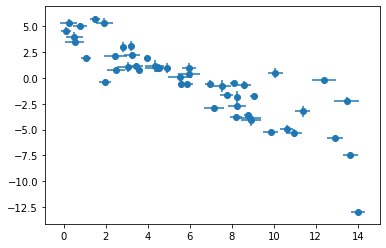

In [ ]:
# First we define some data:
x = np.array([ 0.23397176,  0.11288574,  0.50961469,  0.79911787,  0.52566214,
        1.50423103,  1.05759968,  1.93254129,  1.97368057,  2.46199348,
        2.8082922 ,  2.48448987,  3.18557041,  3.2426218 ,  3.07491281,
        3.97624142,  3.59475299,  4.52290351,  4.44632792,  4.9194819 ,
        3.43477682,  4.33252443,  5.53803749,  5.9694292 ,  6.96247836,
        5.87545248,  5.95249939,  7.55538808,  8.09503967,  5.57724702,
        8.25834164,  7.75371055,  8.57417011,  7.16522482,  8.76276191,
        8.25800109,  8.85517661, 10.62058448,  8.91969572,  8.21046701,
        9.05865873, 12.40087501,  9.86730305, 10.08400622, 10.96808943,
       11.3766884 , 14.01166776, 13.64927879, 12.91979521, 13.47962809])
xerr = np.array([0.39707461, 0.25286896, 0.40876382, 0.33422734, 0.44015499,
       0.23088603, 0.25107607, 0.39855484, 0.29186554, 0.55797678,
       0.12010648, 0.42387588, 0.12751993, 0.38407238, 0.51137741,
       0.17259736, 0.10992658, 0.12621551, 0.55812833, 0.10497772,
       0.32221105, 0.44205587, 0.55420819, 0.51460545, 0.21683453,
       0.29253898, 0.33786511, 0.42698222, 0.18027914, 0.1117489 ,
       0.10372124, 0.3186137 , 0.35795788, 0.46816197, 0.19754305,
       0.4101803 , 0.52614458, 0.31444343, 0.4971158 , 0.3011785 ,
       0.16670916, 0.58577319, 0.3536859 , 0.35960165, 0.37355915,
       0.34889201, 0.31134202, 0.36053818, 0.35934637, 0.59438089])
y = np.array([  5.33159863,   4.54207063,   3.94714832,   5.07835022,
         3.48107278,   5.75684067,   1.96142563,   5.37431185,
        -0.36494822,   2.10337149,   2.98365343,   0.78280289,
         3.13322895,   2.2306922 ,   1.07370918,   1.95343259,
         0.74043931,   1.00071999,   0.96095849,   0.9630811 ,
         1.16994485,   1.20598939,   0.09682621,   0.4290044 ,
        -0.57584825,  -0.53772109,   0.98842269,  -0.76816703,
        -0.49606409,  -0.60852032,  -1.82310651,  -1.69694637,
        -0.6495982 ,  -2.90039355,  -3.63629452,  -2.69475927,
        -3.88547614,  -4.95450567,  -4.08394741,  -3.75948239,
        -1.76474007,  -0.2151749 ,  -5.24217571,   0.47526216,
        -5.31799796,  -3.21582053, -12.99338521,  -7.43975556,
        -5.7743399 ,  -2.21306606])
yerr = np.array([0.42537167, 0.41059338, 0.48075352, 0.24533628, 0.13800163,
       0.22955306, 0.16164972, 0.43055699, 0.12072778, 0.3339441 ,
       0.51044773, 0.31123917, 0.47911244, 0.29986134, 0.46914146,
       0.31812468, 0.25274154, 0.39277097, 0.34739   , 0.45935337,
       0.32571458, 0.58467079, 0.15559012, 0.23166097, 0.35361529,
       0.17283631, 0.50050884, 0.59724943, 0.13159362, 0.38846466,
       0.5793877 , 0.17410052, 0.38810178, 0.30507875, 0.10496006,
       0.16885583, 0.38571698, 0.40130093, 0.54612869, 0.15087449,
       0.26459806, 0.22369835, 0.33098201, 0.47549512, 0.39043335,
       0.53012881, 0.19095729, 0.27526493, 0.22856709, 0.39380301])

import matplotlib.pyplot as plt

plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='o')

Next we have to define the function that emcee will sample from, which in this case is the posterior. To make it easier to read, we split it into three functions - a prior, a likelihood, and a posterior, where the posterior calls the prior and the likelihood. The likelihood is the familiar Gaussian likelihood
$\log \mathcal{L} \propto -\frac{1}{2}\sum\limits_{i}^{} \frac{\left(y_{i,\mathrm{obs}} - y_{i,\mathrm{mod}}\right)^2}{\sigma_i^2} $ where constant terms have been dropped for brevity. As a reminder, Bayes' Theorum is $P\left(A|B\right) = \frac{P\left(B|A\right)P\left(A\right)}{P\left(B\right)}$ which for inference becomes $P\left(M|D\right) = \frac{P\left(D|M\right)P\left(M\right)}{P\left(D\right)}$. MCMC is insensitive to the normalisation of the problem, and $P\left(D|M\right)$ is the likelihood, so we actually consider the case $\log P\left(M|D\right) \propto \log\mathcal{L} + \log P\left(M\right)$

In [ ]:
# Emcee and zeus require a function to evaluate for the posterior
# For clarity, we will define separate prior, likelihood and posterior functions

def lnprior(theta):
    '''  This is the prior

    Here we adopt a rather simple flat prior for demonstration purposes
    '''
    if -20 < theta[0] < 0 and 20 > theta[1] > 0:
        return 0
    return -np.inf

def lnlike(theta, x, y, yerr):
    '''  This is the log-likelihood function
    '''

    ymod = theta[0]*x+theta[1] #our model is very simple: y = mx+c
    return -0.5* np.sum((y - ymod)**2 /yerr**2)

def lnprob(theta, x, y, yerr):
    '''   This posterior probability function simply puts the prior and the
          likelihood together
    '''
    lp = lnprior(theta)
    if lp == -np.inf:
        return lp
    return lp+lnlike(theta, x, y, yerr)

ndim = 2 #our model has 2 free parameters


In [ ]:
#Now we set up the sampler for emcee

nwalkers = 100 #emcee is an _ensemble sampler_ which means that it runs
               #many chains simultaneously, and information is pooled across
               #chains. This improves coverage of the parameter space.
nsteps = 5000
sampler_e = emcee.EnsembleSampler(
    nwalkers, ndim, lnprob, args=(x, y, yerr)
)

initial_guess = np.random.randn(100, 2) + np.array([-10, 10])
sampler_e.run_mcmc(initial_guess, nsteps, progress=True);

100%|██████████| 5000/5000 [00:13<00:00, 368.08it/s]


In [ ]:
#And do the same for Zeus, which you can see is very similar

sampler_z = zeus.EnsembleSampler(nwalkers, ndim, lnprob, args=[x,y,yerr])
sampler_z.run_mcmc(initial_guess, nsteps)

Initialising ensemble of 100 walkers...
Sampling progress : 100%|██████████| 5000/5000 [01:19<00:00, 63.22it/s]


And we can plot the distribution of fits against the data for each code quite easily:

<ErrorbarContainer object of 3 artists>

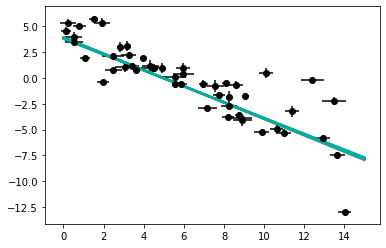

In [ ]:
#Figures go here
flat_samples = sampler_e.get_chain(discard = 400, thin = 40, flat = True)
inds = np.random.randint(len(flat_samples), size=1000)
plot_x = np.linspace(0, 15, 30)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(plot_x, sample[0]*plot_x+sample[1], alpha=0.01, color="orange", label="emcee fits")
flat_samples = sampler_z.get_chain(discard = 400, thin = 40, flat = True)
inds = np.random.randint(len(flat_samples), size=1000)
plot_x = np.linspace(0, 15, 30)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(plot_x, sample[0]*plot_x+sample[1], alpha=0.01, color="cyan", label="zeus fits")
plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='ok')

as you can see, there is no discernable difference between the samples the codes generate in this case.

<a name="ppl"></a>
### Probabilistic programming languages: combining distributions

Now we can do the same thing with the PPLs. We will start with pymc because it is the most widely used.

In [ ]:
try:
    import pymc3 as pm
except ImportError:
    !pip install pymc3
    import pymc3 as pm

First we need to set up the model, define the prior distributions of the parameters, and how that relates to the likelihood:

In [ ]:
basic_model = pm.Model()

with basic_model:

    # Priors for unknown model parameters are defined as distributions
    m = pm.Uniform("m", lower=-20, upper=0)
    c = pm.Uniform("c", lower=0, upper=20)

    # Expected value of outcome
    y_mod = c + m * x

    # Likelihood (sampling distribution) of observations, assuming Gaussian likelihood
    # mean of the gaussian is the expected value above, uncertainty is our observed uncertainty (in this case)
    Y_obs = pm.Normal("Y_obs", mu=y_mod, sigma=yerr, observed=y)

Notice how the model is defined in terms of distributions and operations on them, instead of as a function that returns the likelihood. This makes a number of optimisations possible.

Then we can do some sampling

In [ ]:
with basic_model:
    # draw 5000 posterior samples
    trace_pymc = pm.sample(5000, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [c, m]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 21 seconds.
The number of effective samples is smaller than 25% for some parameters.


At first glance, pymc appears to be much faster than emcee or zeus. emcee needed 15 seconds to produce 5000 samples for this problem, but pymc needed 21 seconds to produce 12000 samples. It even tells us the effective sample size, and thanks to using NUTS it can identify divergences too. However, it is important to note that while pymc ran 2 chains of 6000, emcee actually had 100 walkers, and therefore produced 500,000 samples in 15 seconds!

In [ ]:
import arviz as az
with basic_model:
    display(az.summary(trace_pymc, round_to=2))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
m,-0.78,0.01,-0.80,-0.76,0.0,0.0,2317.24,3289.81,1.0
c,3.88,0.06,3.76,4.01,0.0,0.0,2238.88,3032.58,1.0


Plotting the fits is also quite easy:

/usr/local/lib/python3.7/dist-packages/pymc3/plots/posteriorplot.py:62: DeprecationWarning: The `plot_posterior_predictive_glm` function will migrate to Arviz in a future release. 
Keep up to date with `ArviZ <https://arviz-devs.github.io/arviz/>`_ for future updates.
  DeprecationWarning,


<ErrorbarContainer object of 3 artists>

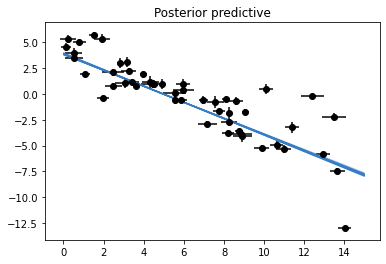

In [ ]:
lm = lambda x, s: s["c"] + s["m"] * x

pm.plot_posterior_predictive_glm(
    trace_pymc,
    lm=lm,
    eval=np.linspace(0, 15, 10),
    samples=200,
    color="#357EC7",
    alpha=0.3,
    zorder=2,
)

ax = plt.gca()
ax.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='ok')

### Pyro

Now we can also try with pyro, which follows similar underlying principles but a different design philosophy. As it is built on Torch instead of Tensorflow, there are some differences.

In [ ]:
try:
    import pyro
except ImportError:
    !pip3 install torch torchvision torchaudio
    !pip install pyro-ppl
    import torch
    import pyro
    import pyro.distributions as dist
    import pyro.poutine as poutine
    from pyro.infer import MCMC, NUTS

     |████████████████████████████████| 718 kB 26.9 MB/s 
     |████████████████████████████████| 750.6 MB 10 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.11.0 which is incompatible.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.11.0 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.11.0 which is incompatible.


In [ ]:
pyro.set_rng_seed(0)

def model(yerr):
    m = pyro.sample("m", dist.Uniform(-20 * torch.ones(1), torch.zeros(1)))
    c = pyro.sample("c", dist.Uniform(torch.zeros(1), 20 * torch.ones(1)))

    theta = c + torch.tensor(x) * m

    return pyro.sample("obs", dist.Normal(theta, yerr))


def conditioned_model(model, yerr, y):
    return poutine.condition(model, data={"obs": y})(yerr)

In [ ]:
nuts_kernel = NUTS(conditioned_model, jit_compile=True)
mcmc = MCMC(
        nuts_kernel,
        num_samples=5000,
        warmup_steps=1000,
        num_chains=2,
    )
mcmc.run(model, torch.tensor(yerr), torch.tensor(y))
mcmc.summary(prob=0.5)

/usr/local/lib/python3.7/dist-packages/pyro/infer/mcmc/api.py:500: UserWarning: num_chains=2 is more than available_cpu=1. Chains will be drawn sequentially.
  num_chains, available_cpu
Warmup:   0%|          | 0/6000 [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  import sys
Warmup:   0%|          | 0/6000 [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause th


                mean       std    median     25.0%     75.0%     n_eff     r_hat
      c[0]      3.88      0.07      3.88      3.84      3.93   2648.77      1.00
      m[0]     -0.78      0.01     -0.78     -0.79     -0.77   2550.26      1.00

Number of divergences: 0


One of the nice things about pyro is that it is easy to move your inference to a GPU if you have access to them. Simply execute the following cell to change the default tensor type to single-precision floating point allocated on a cuda device. Then when you re-run the above pyro examples it should automatically allocate all memory on the GPU (if you have one) and run the sampler there. For some problems and datasets this could result in your inference speeding up by a factor of 100.

In [ ]:
#torch.set_default_tensor_type(torch.cuda.FloatTensor) #Uncomment this line to switch everything to GPUs, then re-run all the cells above related to pyro
#torch.set_default_tensor_type(torch.FloatTensor) #If you want to switch back to CPU computing, comment out the above line and uncomment this one

### Numpyro

Finally, we come to numpyro, which uses numpy and jax instead of a tensor library.

In [ ]:
import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import logsumexp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

try:
    import numpyro
except ImportError:
    !pip install numpyro
    import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as npdist
from numpyro import handlers
from numpyro.infer import MCMC as MCMCnp, NUTS as NUTSnp

     |████████████████████████████████| 283 kB 25.5 MB/s 


In [ ]:
def model_np(x, y, yerr):
    m = numpyro.sample("m", npdist.Uniform(-20 , 0))
    c = numpyro.sample("c", npdist.Uniform(0, 20))

    theta = c + x * m

    numpyro.sample("obs", npdist.Normal(theta, yerr), obs=y)

In [ ]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
Unable to initialize backend 'gpu': FAILED_PRECONDITION: No visible GPU devices.
Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.


In [ ]:
kernel = NUTSnp(model_np, target_accept_prob=0.9)
mcmc = MCMCnp(kernel, num_warmup=1000, num_samples=5000)
mcmc.run(
    rng_key_,
    x=x,
    y=y,
    yerr=yerr,
)
mcmc.print_summary()
samples_4 = mcmc.get_samples()

sample: 100%|██████████| 6000/6000 [00:12<00:00, 465.34it/s, 11 steps of size 4.08e-01. acc. prob=0.91]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         c      3.88      0.06      3.88      3.77      3.98   1342.46      1.00
         m     -0.78      0.01     -0.78     -0.80     -0.77   1347.84      1.00

Number of divergences: 0


Notice how all 3 PPLs give identical answers, and both pymc and numpyro are extremely fast. In general, if it's not too much work to specify your likelihood with a PPL, it's better to use one rather than a black-box code. However, with many of the models we want to use in astronomy this might be very difficult because the code is long or written in a different language (e.g. C, FORTRAN, C++).

<a name="interpret"></a>
# Interpreting the output

In this section, we will use the output from emcee. However, it is also quite easy to equivalent results for the other codes (for zeus it is again almost identical to emcee). In a later section, we will demonstrate a package that makes many of these steps even easier for all samplers.

<a name="converge"></a>
## Is the output converged? Do I have enough independent samples?

MCMC gives us *samples* from the posterior PDF of the model parameters. These samples are generated in *chains* such that consecutive points may be correlated. Therefore, the first thing to check is whether the chains are long enough to give enough independent samples from the distribution.

One way of visualising this is the *trace* of the chains. The chains should rapidly converge to one region of parameter space. Comparing multiple chains (emcee's ensemble-sampling approach is particularly useful here) allows us to check that everything is consistent.

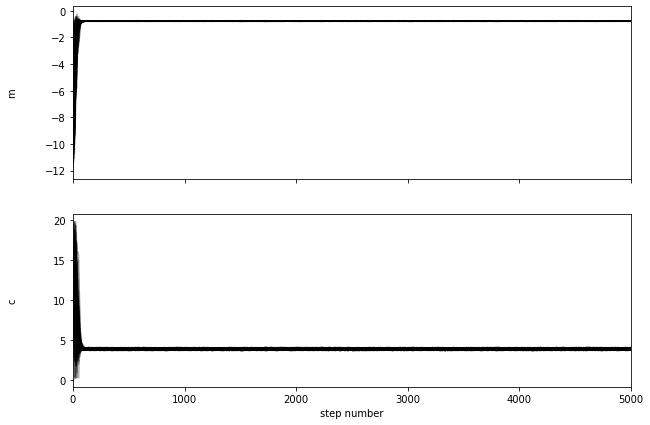

In [ ]:
#get the chains from the sampler - in this case I get them from emcee, but they can come from the other samplers pretty easily too
samples = sampler_e.get_chain()
flat_samples = sampler_e.get_chain(flat=True)

import matplotlib.pyplot as plt

#trace plots first

fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
fig.patch.set_facecolor('white')
labels = ["m", "c"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

You can see that for the first ~100 steps, the chains have not converged to the final region of parameter space. This period while the chains are moving around is referred to as "burn-in".

We can also check the autocorrelation time (in terms of number of samples) for the chains. This gives us some idea of whether we have enough independent samples.

In [ ]:
#emcee has a convenience method for this, so we can easily extract the results
tau = sampler_e.get_autocorr_time(quiet=True)
print(tau)
taus = [tau]

[28.10279317 42.64629499]


But there are some caveats. For example, the autocorrelation time can appear short if we don't compute long enough MCMC chains to properly capture the autocorrelation behaviour

In [ ]:
steps=250
sampler_e2 = emcee.EnsembleSampler(
    nwalkers, ndim, lnprob, args=(x, y, yerr)
)
sampler_e2.run_mcmc(initial_guess,steps)
tau = sampler_e2.get_autocorr_time(quiet=True)
print(tau)
taus = [tau]

for i in range(19): #add more steps in chunks of 500 until we have 5000 steps, updating the autocorrelation time each 500 steps
  sampler_e2.run_mcmc(sampler_e.get_last_sample(),steps)
  tau = sampler_e2.get_autocorr_time(quiet=True)
  print(tau)
  taus.append(tau)
#sampler.run_mcmc(pos,steps*20)
#tau = sampler.get_autocorr_time()
#print(tau)

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 5;
tau: [22.14349327 27.00289384]


[22.14349327 27.00289384]


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 10;
tau: [26.49295971 36.56003021]


[26.49295971 36.56003021]


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 15;
tau: [27.60467102 39.75640727]


[27.60467102 39.75640727]


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [28.03062391 41.04798714]


[28.03062391 41.04798714]


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 25;
tau: [28.23107357 41.68204621]


[28.23107357 41.68204621]


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 30;
tau: [28.34226652 42.01539516]


[28.34226652 42.01539516]


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 35;
tau: [28.40508949 42.20567065]


[28.40508949 42.20567065]


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 40;
tau: [28.44752104 42.31933571]


[28.44752104 42.31933571]
[28.47598543 42.38315433]
[28.49586149 42.41158791]
[28.51017455 42.42507569]
[28.52073055 42.42488166]
[28.52866069 42.4151005 ]
[28.53470223 42.39841262]
[28.53935202 42.37995575]
[28.54295454 42.3542614 ]
[28.54575461 42.32566843]
[28.54792994 42.29482898]
[28.54961202 42.26222778]
[28.55089976 42.22823117]


Text(0.5, 0, 'Step')

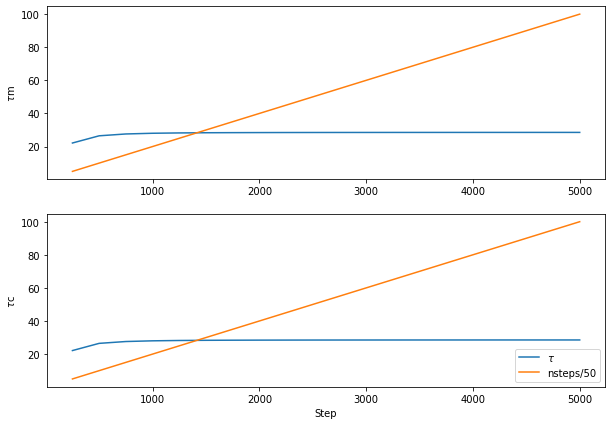

In [ ]:
taus = np.array(taus)
xs = (np.arange(20) + 1) * steps
figt, axest = plt.subplots(2, figsize =(10, 7), sharey = True)
figt.patch.set_facecolor('white')
for i in range(ndim):
  ax = axest[i]
  ax.plot(xs, taus[:,0], label=r"$\tau$")
  ax.plot(xs, xs/50, label="nsteps/50")
  ax.set_ylabel(r"$\tau$" + labels[i])
ax.legend(loc="lower right")
ax.set_xlabel("Step")

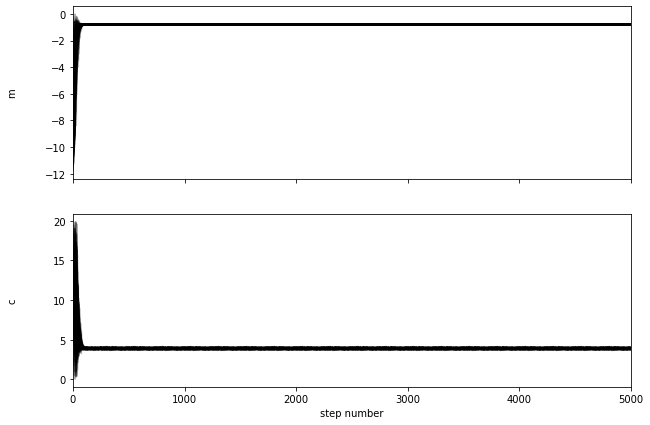

In [ ]:
samples = sampler_e2.get_chain()

fig2, axes2 = plt.subplots(ndim, figsize=(10, 7), sharex=True)

for i in range(ndim):
    ax = axes2[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes2[-1].set_xlabel("step number");

If we trust these numbers, we can now discard the first chunk as burn in, and thin the chains to minimise correlation and flatten them (combine the chains from different walkers) for further analysis.

In [ ]:
flat_samples = sampler_e2.get_chain(discard = 400, thin = 40, flat = True) #Thin is chosen to be ~tau/2, and discard ~ 10* tau

These are great ways to qualify the convergence or mixing of your MCMC. However, the gold standard is the Rubin-Gelman *potential scale reduction factor* or $\hat{R}$. This is the `r_hat` quantity reported by `arviz` when you use `pymc`, `pyro` or `numpyro`. It measures the ratio of the variance of a single chain to the variance between different chains - the closer $\hat{R}$ is to 1, the better. The typical rule of thumb is that $\hat{R} > 1.01$ is unacceptable.

<a name="ppcs"></a>
## Does my model represent my data well?

Once we're sure we've computed enough samples we can check whether our model actually reproduces our data. We're Bayesians, so we don't have any sort of absolute measure of goodness of fit, only relative ones, so we can only do this through visualisation.

Hence, we use a technique called *posterior predictive checks*, whereby we draw samples from the posterior and evaluate the model and compare it to the data

<ErrorbarContainer object of 3 artists>

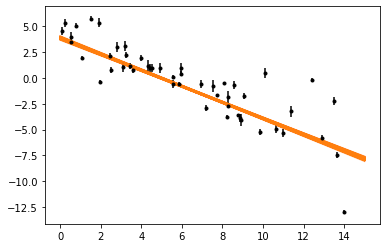

In [ ]:
inds = np.random.randint(len(flat_samples), size=1000)
plot_x = np.linspace(0, 15, 30)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(plot_x, sample[0]*plot_x+sample[1], "C1", alpha=0.1)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)

<a name="parameters"></a>
## What do the results tell me about the distribution of my parameters?

Now, we're sure that we have enough samples and that our model is representative of our data, we can see what the posterior distributions of the model can tell us. The most straightfoward thing to do is to get point estimates and their credible intervals. These are determined from the 1D distribution of the posterior after marginalising out all other parameters, which is straightforward with MCMC samples:

In [ ]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i]).replace("$", "")
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Another common tool is the triangle (or corner) plot which shows the 2D marginal distributions of the parameters, which we can explore to see if parameters are correlated.

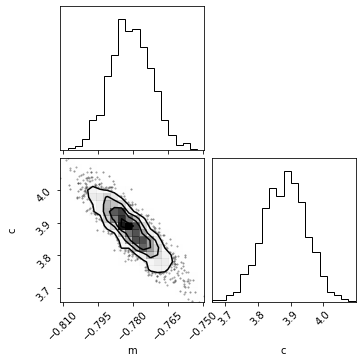

In [ ]:
try:
  import corner
except ImportError:
  !pip install corner
  import corner

#mask_samples = np.logical_and(flat_samples)
fig = corner.corner(
    flat_samples[flat_samples[:,1] > 0], labels=labels#, truths=[m_true, b_true, np.log(f_true)]
);
fig.patch.set_facecolor('white')

As we can see, the parameters have correlations with the others. We can try to quantify some of those correlations by computing the numerical correlation matrix of the parameters, e.g.

In [ ]:
cov = np.cov(flat_samples, rowvar=False)
print(cov)

[[ 7.97595164e-05 -5.07325483e-04]
 [-5.07325483e-04  4.36716810e-03]]


Which shows the anti-correlation between the parameters on the off-diagonal elements. However, this doesn't always capture the whole picture, which is why the corner plot is useful. The correlation matrix can't tell us if the correlations are non-Gaussian, but we can see that by eye from, for example banana-shaped contours.

<a name="priorsensitivity"></a>
## Does the choice of prior affect the results?

We should also check that our choice of prior doesn't unnecessarily alter the results. This is known as *prior sensitivity testing*. Essentially, we must recompute the posterior to see what it would look like under the assumption of a different prior. Most of the time, this requires us to re-run the MCMC with the different prior. The code is included here to demonstrate (and provide a complete overview of the code in one place) but executing it is left as an exerise for the reader to compare the outputs.

In [ ]:
from scipy.stats import t, norm

m_prior = norm(0,3) #a normal distribution with standard deviation of 3
c_prior = t(2, loc=0, scale=2)
#Redefine the prior
def lnprior_new(theta):
    '''  This is the prior

    Just for demonstration purposes, we will adopt rather strange priors
    '''

    return m_prior.logpdf(theta[0]) + c_prior.logpdf(theta[1])

def lnprob_new(theta, x, y, yerr):
    '''   This posterior probability function simply puts the prior and the
          likelihood together
    '''
    lp = lnprior_new(theta)
    if lp == -np.inf:
        return lp
    return lp+lnlike(theta, x, y, yerr)

ndim = 2 #our model has 2 free parameters

In [ ]:
#Now we set up the sampler for emcee

nwalkers = 100 #emcee
nsteps = 5000
sampler_e_new = emcee.EnsembleSampler(
    nwalkers, ndim, lnprob_new, args=(x, y, yerr)
)

initial_guess = np.random.randn(100, 2) + np.array([-10, 10])
sampler_e_new.run_mcmc(initial_guess, nsteps, progress=True);

100%|██████████| 5000/5000 [03:12<00:00, 26.03it/s]


[25.53187828 37.6334549 ]


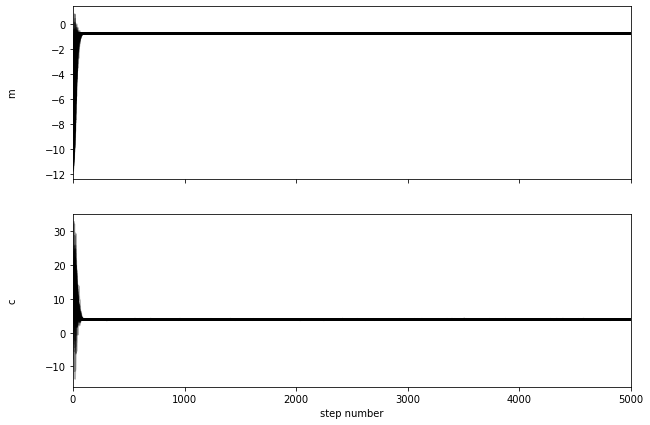

In [ ]:
#get the chains from the sampler - in this case I get them from emcee, but they can come from the other samplers pretty easily too
samples = sampler_e_new.get_chain()
flat_samples = sampler_e_new.get_chain(flat=True)

import matplotlib.pyplot as plt

#trace plots first

fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
fig.patch.set_facecolor('white')
labels = ["m", "c"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

tau = sampler_e_new.get_autocorr_time(quiet=True)
print(tau)

flat_samples = sampler_e_new.get_chain(discard = 400, thin = 40, flat = True) #Thin is chosen to be ~tau/2, and discard ~ 10* tau

<IPython.core.display.Math object>

<IPython.core.display.Math object>

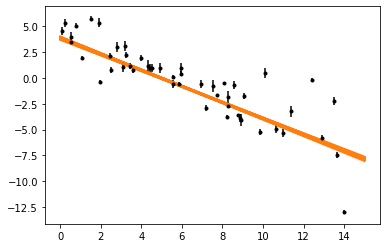

In [ ]:
inds = np.random.randint(len(flat_samples), size=1000)
plot_x = np.linspace(0, 15, 30)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(plot_x, sample[0]*plot_x+sample[1], "C1", alpha=0.1)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)

from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i]).replace("$", "")
    display(Math(txt))

[[ 7.89010896e-05 -4.89112105e-04]
 [-4.89112105e-04  4.20111670e-03]]


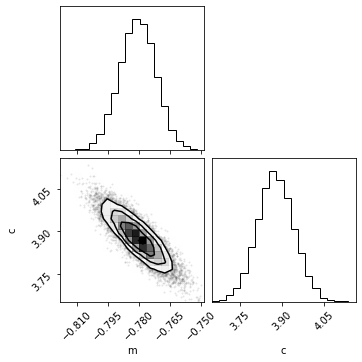

In [ ]:
#mask_samples = np.logical_and(flat_samples)
fig = corner.corner(
    flat_samples[flat_samples[:,1] > 0], labels=labels#, truths=[m_true, b_true, np.log(f_true)]
);
fig.patch.set_facecolor('white')

cov = np.cov(flat_samples, rowvar=False)
print(cov)

We can see that this particular choice of prior doesn't make a significant difference. Try choosing different priors and see how different it needs to be to substantially alter the result.

<a name="arviz"></a>
# Visualisation and tests with arviz

The above tests were all written using simple python to demonstrate what do to, why, and what it tells you. However, a lot of these tests are implemented in the statistics package arviz, which also produces convenient visualisations for you. Many MCMC packages automatically produce output that arviz recognises, while others like emcee and zeus can easily be converted to arviz InferenceData objects.

For example, the trace can be very easily reproduced with arviz:

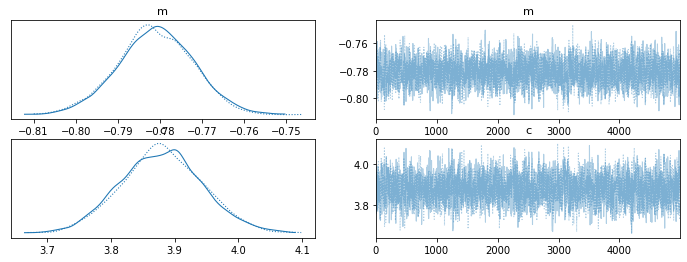

In [ ]:
with basic_model:
    az.plot_trace(trace_pymc);

As can the corner plot

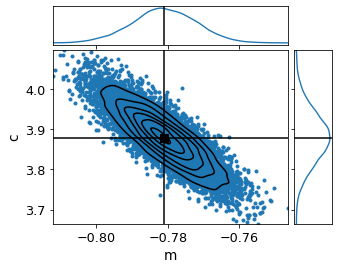

In [ ]:
with basic_model:
    ax = az.plot_pair(
    trace_pymc,
    kind=["scatter", "kde"],
    kde_kwargs={"fill_last": False},
    marginals=True,
    point_estimate="median",
    figsize=(5, 4),
    )


In fact, it can produce several different versions of the corner plot, depending on your preference:

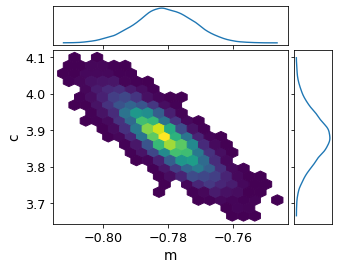

In [ ]:
with basic_model:
    ax = az.plot_pair(
    trace_pymc,
    kind="hexbin",
    marginals=True,
    figsize=(5, 4),
    )

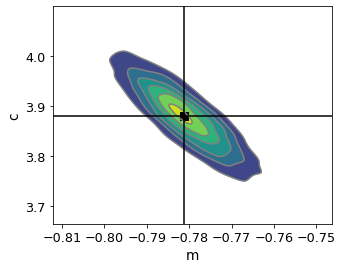

In [ ]:
with basic_model:
    ax = az.plot_pair(
    trace_pymc,
    kind="kde",
    point_estimate="median",
    figsize=(5, 4),
    )

In addition, it can produce a wide variety of useful statistics. It can automatically calculate the Effective Sample Size (ESS), Monte Carlo Standard Error (MCSE) and Gelman & Rubin potential scale reduction factor ($\hat{R}$). There is also a convenient function for the  highest-density interval for the parameters.

In [ ]:
with basic_model:
    print(az.hdi(trace_pymc, hdi_prob=.683))

<xarray.Dataset>
Dimensions:  (hdi: 2)
Coordinates:
  * hdi      (hdi) <U6 'lower' 'higher'
Data variables:
    m        (hdi) float64 -0.7887 -0.7711
    c        (hdi) float64 3.817 3.946


It also has functions for some useful statistics like the widely-applicable information criterion, which is a model-selection tool for MCMC chains

In [ ]:
with basic_model:
    w = az.waic(trace_pymc, pointwise=True)
    print(w)

Computed from 10000 by 50 log-likelihood matrix

          Estimate       SE
elpd_waic -1868.60   742.16
p_waic      363.39        -

There has been a warning during the calculation. Please check the results.


/usr/local/lib/python3.7/dist-packages/arviz/stats/stats.py:1460: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


Or leave-one-out cross validation

In [ ]:
with basic_model:
    l = az.loo(trace_pymc, pointwise=True)
    print(l)

/usr/local/lib/python3.7/dist-packages/arviz/stats/stats.py:927: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/usr/local/lib/python3.7/dist-packages/arviz/stats/stats.py:695: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 10000 by 50 log-likelihood matrix

         Estimate       SE
elpd_loo -1731.10   658.95
p_loo      225.89        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       40   80.0%
 (0.5, 0.7]   (ok)          1    2.0%
   (0.7, 1]   (bad)         4    8.0%
   (1, Inf)   (very bad)    5   10.0%



<a name="problems"></a>
# Common problems

MCMC is far from infallible, and you may encounter a wide variety of problems when trying to fit your data. The plots above will help you diagnose these issues, but what can you do when you encounter them? How can you prevent them?

1.   Not enough samples/chains never converge
> This is a common problem, often referred to as "poor mixing". The obvious answer would be to run longer chains, but this can be wasteful if you're not sure this is the only reason. Try seeing if you can reparametrise your model - e.g. fitting the log of parameters that have large dynamic range, especially if there is a mixture of parameters with different dynamic ranges. If this doesn't work, try changing to a different sampler if possible.
2.   Chains don't explore parameter space well
> This is another case similar to poor mixing, and is in some senses a feature of MCMC. This can also be a case of problems in the parametrisation of the model, so it can be worth checking if changing it improves the behaviour. You can also try changing the way new samples are proposed, or switching to a different sampler.
3.   Chains get stuck in local maxima
> This is a feature of MCMC, but there can be ways to minimise it. One option is to run more chains starting from different positions and see where different chains end up. For ensemble samplers like emcee and zeus, increasing the number of walkers can also be a solution which works along the same lines. Some codes provide the means to change parameters related to how new steps are proposed, which can also be a way to get chains out of local maxima and toward the global one. For example, emcee and zeus have Moves() objects designed for this, which are very flexible and can provide a high degree of control. Another option is to try a different sampler: in particular, if you're using emcee you may find that zeus does significantly better in this regard, as this is precisely what slice sampling is designed to achieve.
4.   Model doesn't represent data well
> Check for bugs in your model! This is a common problem, as **all** code has bugs. Another issue may be that it's just stuck in a local maximum, so _looks_ like it doesn't represent the data well, when another set of parameters might. Otherwise, this might seem obvious but **try a different model!**

All of these are somewhat related, as they are to do with how the parameter space is explored. Try comparing different MCMC implementations or different packages and see if you get different results. Try completely different methods, like the ones below in "when not to use MCMC". This can be particularly useful if your results seems to be sensitive to the initial conditions, or if your more is expensive enough that you can't afford to keep running tests.



<a name="alternatives"></a>
# When not to use MCMC, and what to use instead

MCMC is very powerful, but it is not always the best tool for the job at hand. There are a number of cases where you might want to explore other tools instead.

### Optimisation
MCMC is intended to _sample_ from a distribution; while it can be used for optimisation, that's not the main objective. If all you are interested in is the _maximum a posteriori_ solution, and you can evaluate the gradient of the posterior, there is a wide range of **_stochastic gradient descent_** algorithms around. These scale to almost arbitrarily large numbers of dimensions, and can tackle a wide variety of problems. Consider trying:
- ADAM (Adaptive Moment Estimation)
- ADAMW (Adaptive Moment Estimation with Weight decay)
- Adagrad

which you will find implementations of in many machine-learning libraries and PPLs.

### Sampling from complex posteriors
When you want to do both optimisation and sampling at the same time, there are a few options. MCMC may work, if the parameter space is not too complex, but if it has many modes or other unpleasant features (e.g. the doughnut function has no overall maximum) MCMC will struggle. In these cases, you may want to consider trying **_nested sampling_**, which takes a different approach. However, it is important to bear in mind that NS was developed for a different objective, which is to calculate the _evidence_ for model selection, and samples from the posterior are just a happy accident. However, as a result of how it goes about this, it has several handy properties for evaluating complex posteriors, such as sampling from the full support of the distribution, effectively finding multiple maxima, and always finding the global maximum (at least, given infinite computing time). Two popular packages for this are dynesty and ultranest.


### Very high-dimensional models
For $n \gtrsim $ several hundred, even gradient-based MCMC like NUTS will struggle with the curse of dimensionality. In this case, there are a few options based on the type of problem you are solving.

In some cases, you can guarantee that the posterior is log-concave. In that case, you may be able to define a _proximal operator_ (don't ask me how to do this). This opens up a class of algorithms including **_proximal MCMC_** and proximal nested sampling, which can easily scale to $n \gtrsim 10^6$ even without gradients. Unfortunately, no packages seem to exist for this yet.

If you can't guarantee these properties for your model, you can adopt approximate inference methods. **_Variational Inference_** is often an effective choice. It works by attempting to find an alternative, tractable distribution which approximates the true posterior. To do so, it works in an ``inference as optimisation'' paradigm, by finding the parameters for the approximate posterior which minimise the Kullback-Liebler divergence from the true posterior. This turns the problem into one of gradient descent, meaning it scales to millions or billions of free parameters. Unlike most other algorithms suggested here, it will even allow for the number of parameters to change during inference. Most probabilistic programming languages have the infrastructure for this.

### Sampling **very** expensive posteriors

MCMC typically requires many hundreds of thousands or millions (or more!) of model evaluations. As a result, if a single model evaluation takes as much as 1 second you're looking at needing in excess of a year of computing time to get a good solution. You can distribute the model evaluations across a cluster, but there are limits to how much this will help, and it won't improve your carbon footprint (in fact, overhead from parallel computation will make it worse). In these situations, there are alternative methods you can choose that may help. All of them rely on different kinds of approximations.

The first case is to look for a distribution that best approximates the posterior itself. This is **_Variation Inference_** as described above. There are several cases, that may be referred to as Variational Bayes, Stochastic Variational Inference, or others. All take a tractable distribution to approximate the posterior and try to find the paramters for that distribution that match best. This is advantageous because it reduces the number of posterior evaluations that are required compared to MCMC while still giving an evaluable posterior (in fact, having an analytical distribution for it can be more useful, as you're not dependent on the samples). In addition to PPLs, the snowline package is quite popular.

The second is to approximate the evaluation of the posterior. This goes by the names **_Approximate Bayesian Computing_** or  **_Likelihood-free Inference_**. This is a type of simulation-based inference in which you produce simulations of the data you are trying to model, and measure some distance between the simulated and observed data, but without attempting to evaluate the likelihood itself. This typically requires the fewest model evaluations, but does suffer more strongly from the curse of dimensionality than most forms of VI. There are a number of python packages out there, notably pyABC and ELFI.

Finally, you can adopt an approximate model and still do ''exact'' inference. You can achieve this by sacrificing physics if the model is complex, or by interpolating between points in a grid of pre-calculated models, then using this new function as the model for the MCMC. However, care is required when interpolating - most physical models are not linear in their parameters, and so interpolation may not follow the truth very closely. Machine-learning techniques such as gaussian-process interpolation or neural-network emulators may do a better job, and while they take longer to train they are still very fast to evaluate once trained.


### When you need an estimate of the evidence

As described above, there are model-selection statistics that work for MCMC samples, but they may not be the best choice for your problem. While the evidence _can_ be derived from MCMC samples, it is often not efficient or is highly uncertain, because MCMC explores only the area around the peaks of the posterior, and not the full prior volume. In those cases, nested sampling is the best choice, as it consistently explores the whole prior volume and can return meaningful uncertainties on the evidence. As a result, it tends to give meaningful evidence estimates with far fewer evaluations than MCMC would require for the same thing. For expensive models, ABC may also be able to give you useful evidence estimates, as can many forms of VI.

<a name="examples"></a>
# Further examples

Now, we can go over some other simple examples relevant to research in general and astronomy in particular.









<a name="2dunc"></a>
### 1. Regression with uncertainty on x and y

It is rare to have no uncertainty on the independent variable in observations, but this uncertainty is often ignored because many fitting methods can only handle uncertainty on the dependent variable. Remember that when we created our test data earlier, there were uncertainties on both x and y points - that's because that's how they were really generated. We can see how much bias the mis-specification of the model introduces on the parameters.

You can find this model laid out in section 7 of David Hogg et al's excellent notes on [fitting a model to data](https://arxiv.org/abs/1008.4686). I won't go over the mathematics here, but equation numbers refer to those given by Hogg+.

In [ ]:
S = np.array([[xerr, np.zeros_like(xerr)], [np.zeros_like(yerr), yerr]])
print(S.shape)
m = -0.7
b = 4
theta = [m, b]
nu_hat = 1/np.sqrt(1+theta[0]**2) * np.array([-1*theta[0], 1])
print(nu_hat.shape)
Z = np.array([x, y])
print(np.matmul(nu_hat.T, Z) - (theta[1]* nu_hat[1]))
print([np.matmul(S[:,:,i], nu_hat) for i in range(S.shape[2]) ])
delta = np.matmul(nu_hat.T, Z) - (theta[1]* nu_hat[1])
sigma_sq = np.zeros(S.shape[2])
for i in range(S.shape[2]):
    s = S[:,:,i]
    sigma_sq[i] = np.matmul(nu_hat.T, np.matmul(s, nu_hat))
#sigma_sq = np.matmul(nu_hat.T, np.matmul(S, nu_hat))
print(sigma_sq)
print(delta**2 / (2*sigma_sq))
print(np.sum(delta**2 / (2*sigma_sq)))

(2, 2, 50)
(2,)
[ 1.2250621   0.50881728  0.24894705  1.34168293 -0.1236743   2.30187981
 -1.0635716   2.2341198  -2.44407343 -0.14191806  0.77782628 -1.21086918
  1.11671816  0.41004807 -0.63396414  0.60361138 -0.60888069  0.13660893
  0.06012182  0.33319672 -0.34875635  0.19559694 -0.0217486   0.49776928
  0.24403821 -0.34809521  0.94635399  0.42649593  0.95888121 -0.5771058
 -0.03462677 -0.22065929  1.10786443 -1.54403604 -1.23078224 -0.74890783
 -1.38192342 -1.2453116  -1.50751814 -1.648422    0.47214059  3.65822903
 -1.91295862  2.8952201  -1.34381509  0.61267189 -5.88635976 -1.5444655
 -0.5984352   2.64011708]
[array([0.22770734, 0.34847805]), array([0.14501083, 0.3363712 ]), array([0.23441066, 0.39384863]), array([0.19166679, 0.20098731]), array([0.25241231, 0.11305534]), array([0.13240444, 0.18805719]), array([0.14398267, 0.13242861]), array([0.22855619, 0.35272603]), array([0.1673739 , 0.09890405]), array([0.31997867, 0.27357767]), array([0.06887654, 0.41817507]), array([0.243

In [ ]:
#Doing it first with emcee:

def lnprior_2d(theta):
    if -20 < theta[0] < 0 and 20 > theta[1] > 0:
        return 0
    return -np.inf

def lnlike_2d(theta, x, y, xerr, yerr):
    S = np.array([[xerr, np.zeros_like(xerr)], [np.zeros_like(yerr), yerr]]) #Create the covariance tensor, eq 26
    nu_hat = 1/np.sqrt(1+theta[0]**2) * np.array([-1*theta[0], 1]) #Define a unit vector orthogonal to a line with gradient m, eq 29
    delta = np.matmul(nu_hat.T, np.array([x, y])) - (theta[1]* nu_hat[1]) # Displacement from the line, eq 30
    sigma_sq = np.zeros(S.shape[2])
    for i in range(S.shape[2]):
        s = S[:,:,i]
        sigma_sq[i] = np.matmul(nu_hat.T, np.matmul(s, nu_hat))
    return -0.5 * np.sum(delta**2 / sigma_sq)

def lnprob_2d(theta, x, y, xerr, yerr):
    lp = lnprior_2d(theta)
    if lp == -np.inf:
        return lp
    return lp+lnlike_2d(theta, x, y, xerr, yerr)

In [ ]:
nwalkers = 100 #emcee is an _ensemble sampler_ which means that it runs many chains simultaneously, and information is pooled across chains. This improves coverage of the parameter space.
nsteps = 5000
sampler_2d = emcee.EnsembleSampler(
    nwalkers, ndim, lnprob_2d, args=(x, y, xerr, yerr)
)

initial_guess = np.random.randn(100, 2) + np.array([-10, 10])
sampler_2d.run_mcmc(initial_guess, nsteps, progress=True);

100%|██████████| 5000/5000 [02:18<00:00, 36.05it/s]


In [ ]:
tau = sampler_2d.get_autocorr_time(quiet=True)
print(tau)

flat_samples = sampler_2d.get_chain(discard = 1000, thin = 100, flat = True)

[28.43525051 40.01744714]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

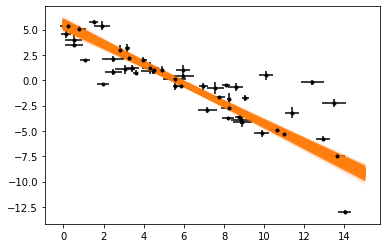

In [ ]:
inds = np.random.randint(len(flat_samples), size=1000)
plot_x = np.linspace(0, 15, 30)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(plot_x, sample[0]*plot_x+sample[1], "C1", alpha=0.1)
plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt=".k", capsize=0)

from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i]).replace("$", "")
    display(Math(txt))

[[ 0.00095669 -0.00596645]
 [-0.00596645  0.04876653]]


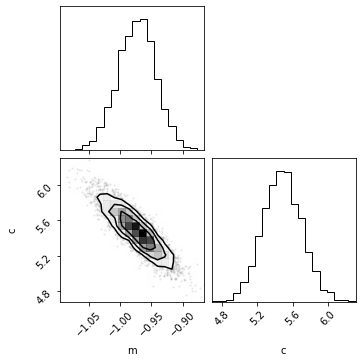

In [ ]:
fig = corner.corner(
    flat_samples[flat_samples[:,1] > 0], labels=labels#, truths=[m_true, b_true, np.log(f_true)]
);
fig.patch.set_facecolor('white')

cov = np.cov(flat_samples, rowvar=False)
print(cov)

We can also attempt to do this with PyMC, in which case things will look quite different. In PyMC there is no need to transform the problem to consider the orthogonal distance of the points from the line. However, this implicitly transforms the case to a _hierarchical model_ (advanced topic I haven't described yet) where the *true* positions of the points, **assuming they really are drawn from a straight line** must also be inferred at the same time as the distribution of lines themselves!

Auto-assigning NUTS sampler...
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
Sequential sampling (2 chains in 1 job)
NUTS: [obs_y, obs_x, m, c]
NUTS: [obs_y, obs_x, m, c]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 37 seconds.
Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 37 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
c,5.61,0.12,5.38,5.85,0.0,0.0,6455.28,7685.78,1.0
m,-1.01,0.02,-1.05,-0.98,0.0,0.0,6331.19,7473.14,1.0
obs_x[0],0.25,0.29,-0.30,0.79,0.0,0.0,23785.59,7745.26,1.0
obs_x[1],0.38,0.22,-0.04,0.78,0.0,0.0,22089.39,6347.61,1.0
obs_x[2],0.99,0.31,0.42,1.56,0.0,0.0,21568.68,7570.37,1.0
...,...,...,...,...,...,...,...,...,...
obs_y[45],-3.21,0.54,-4.23,-2.23,0.0,0.0,30522.83,6740.14,1.0
obs_y[46],-12.99,0.19,-13.35,-12.64,0.0,0.0,24853.19,6653.67,1.0
obs_y[47],-7.44,0.28,-7.97,-6.93,0.0,0.0,29294.60,6920.25,1.0
obs_y[48],-5.78,0.23,-6.21,-5.34,0.0,0.0,27955.21,6571.96,1.0


             mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
c           5.613  0.125   5.383    5.851      0.002    0.001    6455.0   
m          -1.012  0.017  -1.045   -0.981      0.000    0.000    6331.0   
obs_x[0]    0.253  0.292  -0.304    0.786      0.002    0.002   23786.0   
obs_x[1]    0.377  0.220  -0.037    0.784      0.001    0.001   22089.0   
obs_x[2]    0.991  0.310   0.417    1.561      0.002    0.002   21569.0   
...           ...    ...     ...      ...        ...      ...       ...   
obs_y[45]  -3.212  0.538  -4.226   -2.233      0.003    0.002   30523.0   
obs_y[46] -12.993  0.190 -13.346  -12.637      0.001    0.001   24853.0   
obs_y[47]  -7.439  0.277  -7.973   -6.934      0.002    0.001   29295.0   
obs_y[48]  -5.776  0.231  -6.209   -5.339      0.001    0.001   27955.0   
obs_y[49]  -2.214  0.391  -2.958   -1.485      0.002    0.002   25511.0   

           ess_tail  r_hat  
c            7686.0    1.0  
m            7473.0    1.0  
obs_x[0]    

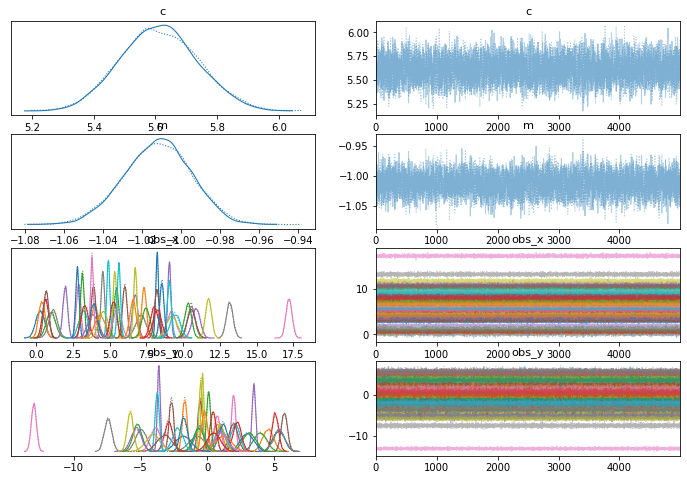

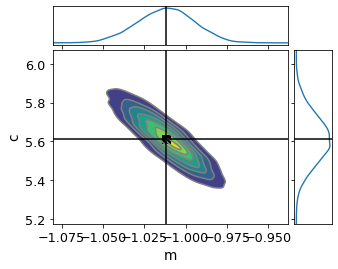

In [ ]:
with pm.Model() as model:
    c = pm.Normal('c', 0, sd=20)
    m = pm.Normal('m', 0, sd=20)

    obs_x = pm.Normal('obs_x', mu=x, sd=xerr, shape=len(x))
    obs_y = pm.Normal('obs_y', mu=y, sd=yerr, shape=len(y))

    likelihood = pm.Normal('y', mu=c + m * obs_x,
                    sd=yerr, observed=y)

    trace_2d = pm.sample(5000, return_inferencedata = True)
    display(az.summary(trace_2d, round_to=2))
    az.plot_trace(trace_2d)

    ax = az.plot_pair(
    trace_2d,
    var_names=["m","c"],
    kind="kde",
    marginals=True,
    point_estimate="median",
    figsize=(5, 4),
    )
    results = az.summary(trace_2d)
    print(results)

We can even examine the inferred true distributions of the data, and compare them with the observed data.

/usr/local/lib/python3.7/dist-packages/pymc3/plots/posteriorplot.py:62: DeprecationWarning: The `plot_posterior_predictive_glm` function will migrate to Arviz in a future release. 
Keep up to date with `ArviZ <https://arviz-devs.github.io/arviz/>`_ for future updates.
  DeprecationWarning,


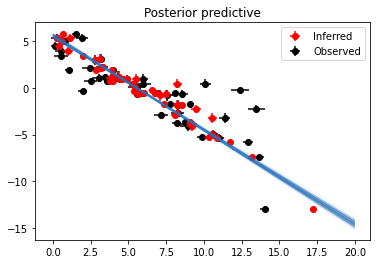

In [ ]:
lm = lambda x, s: s["c"] + s["m"] * x

pm.plot_posterior_predictive_glm(
    trace_2d,
    lm=lm,
    eval=np.linspace(0, 20, 10),
    samples=200,
    color="#357EC7",
    alpha=0.2,
    zorder=4,
)

ax = plt.gca()

#print(results)
x_mod = az.summary(trace_2d, var_names=["obs_x"], filter_vars="like", round_to=2) #results['obs_x'].to_numpy().reshape(len(x))

y_mod = az.summary(trace_2d, var_names=["obs_y"], filter_vars="like", round_to=2) #results['obs_y'].to_numpy().reshape(len(y))
#print(x_mod['mean'])
ax.errorbar(x_mod['mean'], y_mod['mean'], xerr = x_mod['sd'], yerr = y_mod['sd'], fmt='o', color = 'red', zorder = 3, label = "Inferred")
ax.errorbar(x, y, xerr = xerr, yerr = yerr, fmt='o', color = 'black', label='Observed')
ax.legend()

<a name="outliers"></a>
### 2. Linear regression with outliers

Real data are rarely as clean as that above - data get corrupted, or samples are contaminated with interlopers. Therefore, it is important to be able to handle outliers in inference.

You've probably previously seen attempts to do this by pruning outliers *before* fitting, for example by sigma-clipping the data. However, this throws away information, and pruning points can affect the eventual conclusion in unpredictable ways. Hogg et al give a good description of why this is bad, which I attempt to extract the most salient points of here. Sigma clipping does not optimise any (justifiable) objective function. As a result, there is no way to differentiate between the different possible outcomes that result from different starting points.

A slightly more complex option is to change the likelihood function for the data, similar to "robust" fitting methods. The Gaussian likelihood is particularly sensitive to outliers, so by softening the function in some way biases can be reduced. In the extreme case, this could be by taking the L1 norm (which corresponds to a Laplacian likelihood) instead of the L2 norm as a measure of the distance between the model and the data, but more commonly the Gaussian likelihood is replaced by a similar distribution with more significant tails - a T distribution is a common choice, and easy to implement.

In [ ]:
#For the purposes of this example, we exploit some data from Hogg et al

dfhoggs = pd.DataFrame(
    np.array(
        [
            [1, 201, 592, 61, 9, -0.84],
            [2, 244, 401, 25, 4, 0.31],
            [3, 47, 583, 38, 11, 0.64],
            [4, 287, 402, 15, 7, -0.27],
            [5, 203, 495, 21, 5, -0.33],
            [6, 58, 173, 15, 9, 0.67],
            [7, 210, 479, 27, 4, -0.02],
            [8, 202, 504, 14, 4, -0.05],
            [9, 198, 510, 30, 11, -0.84],
            [10, 158, 416, 16, 7, -0.69],
            [11, 165, 393, 14, 5, 0.30],
            [12, 201, 442, 25, 5, -0.46],
            [13, 157, 317, 52, 5, -0.03],
            [14, 131, 311, 16, 6, 0.50],
            [15, 166, 400, 34, 6, 0.73],
            [16, 160, 337, 31, 5, -0.52],
            [17, 186, 423, 42, 9, 0.90],
            [18, 125, 334, 26, 8, 0.40],
            [19, 218, 533, 16, 6, -0.78],
            [20, 146, 344, 22, 5, -0.56],
        ]
    ),
    columns=["id", "x", "y", "sigma_y", "sigma_x", "rho_xy"],
)

dfhoggs["id"] = dfhoggs["id"].apply(lambda x: "p{}".format(int(x)))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [nu, b1_slope, b0_intercept]


Sampling 4 chains for 5_000 tune and 500 draw iterations (20_000 + 2_000 draws total) took 32 seconds.
The acceptance probability does not match the target. It is 0.663061256274522, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8816948978379298, but should be close to 0.8. Try to increase the number of tuning steps.
/usr/local/lib/python3.7/dist-packages/arviz/plots/pairplot.py:183: UserWarning: fill_last and contour will be deprecated. Please use kde_kwargs
  UserWarning,


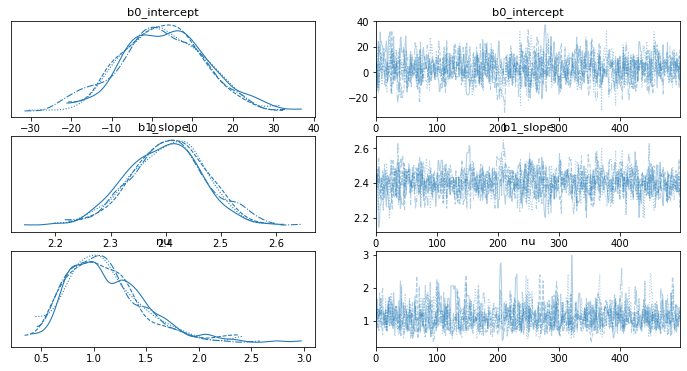

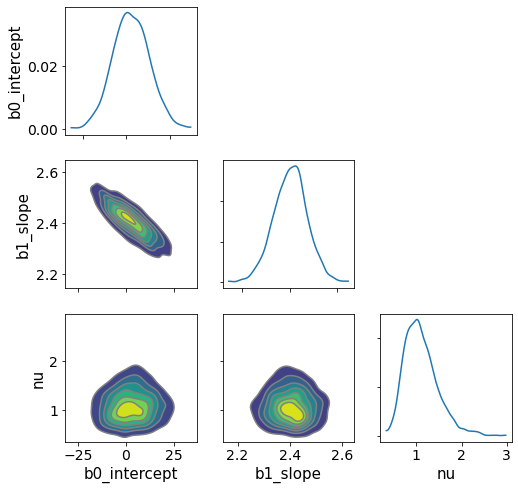

In [ ]:
#Robust (T-likelihood) inference

with pm.Model() as model_T:

    # define weakly informative Normal priors to give Ridge regression
    b0 = pm.Normal("b0_intercept", mu=0, sigma=10)
    b1 = pm.Normal("b1_slope", mu=0, sigma=10)

    # define linear model
    y_est = b0 + b1 * dfhoggs["x"]

    # define prior for StudentT degrees of freedom
    # This controls how "soft" the likelihood is,
    # i.e. how resistant to outliers it is
    # InverseGamma has nice properties:
    # it's continuous and has support x ∈ (0, inf)
    nu = pm.InverseGamma("nu", alpha=1, beta=1)

    # define Student T likelihood
    likelihood = pm.StudentT(
        "likelihood", mu=y_est, sigma=dfhoggs["sigma_y"], nu=nu, observed=dfhoggs["y"]
    )

    trace_T = pm.sample(
        tune=5000,
        draws=500,
        chains=4,
        n_init=50000,
        progressbar=True,
        return_inferencedata=True,
    )

    az.plot_trace(trace_T)

    az.plot_pair(
    trace_T,
    #var_names=["b0_intercept", "b1_slope"],
    kind="kde",
    fill_last=True,
    #divergences=True,
    figsize=[8, 8],
    marginals=True,
    #marginal_kwargs=marginalKwards,
    #group="posterior",
)

An alternative is to attempt to infer which points are outliers at the same time as inferring the model. This is often referred to as an outlier mixture model. You can find this discussed in David Hoggs notes in section 3. In this case, we end up with an additional variable per data point, which is a binary classification of each point as an inlier or outlier. In some senses, the fraction of MCMC samples in which a given datum is an outlier can be translated to a classification probability that it is an outlier. This is another kind of hierarchical model.

Sequential sampling (4 chains in 1 job)
CompoundStep
>NUTS: [frac_outliers, sigma_y_out, y_est_out, b1_slope, b0_intercept]
>BinaryGibbsMetropolis: [is_outlier]


Sampling 4 chains for 10_000 tune and 500 draw iterations (40_000 + 2_000 draws total) took 252 seconds.
/usr/local/lib/python3.7/dist-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.7/dist-packages/arviz/plots/pairplot.py:183: UserWarning: fill_last and contour will be deprecated. Please use kde_kwargs
  UserWarning,


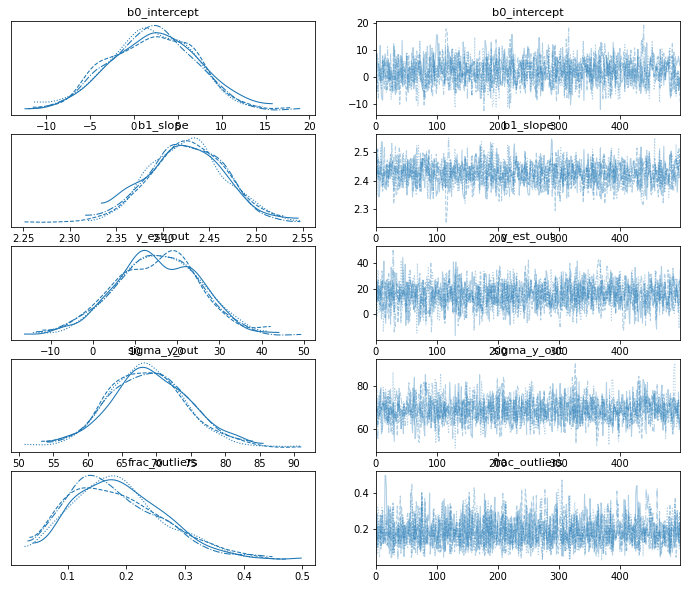

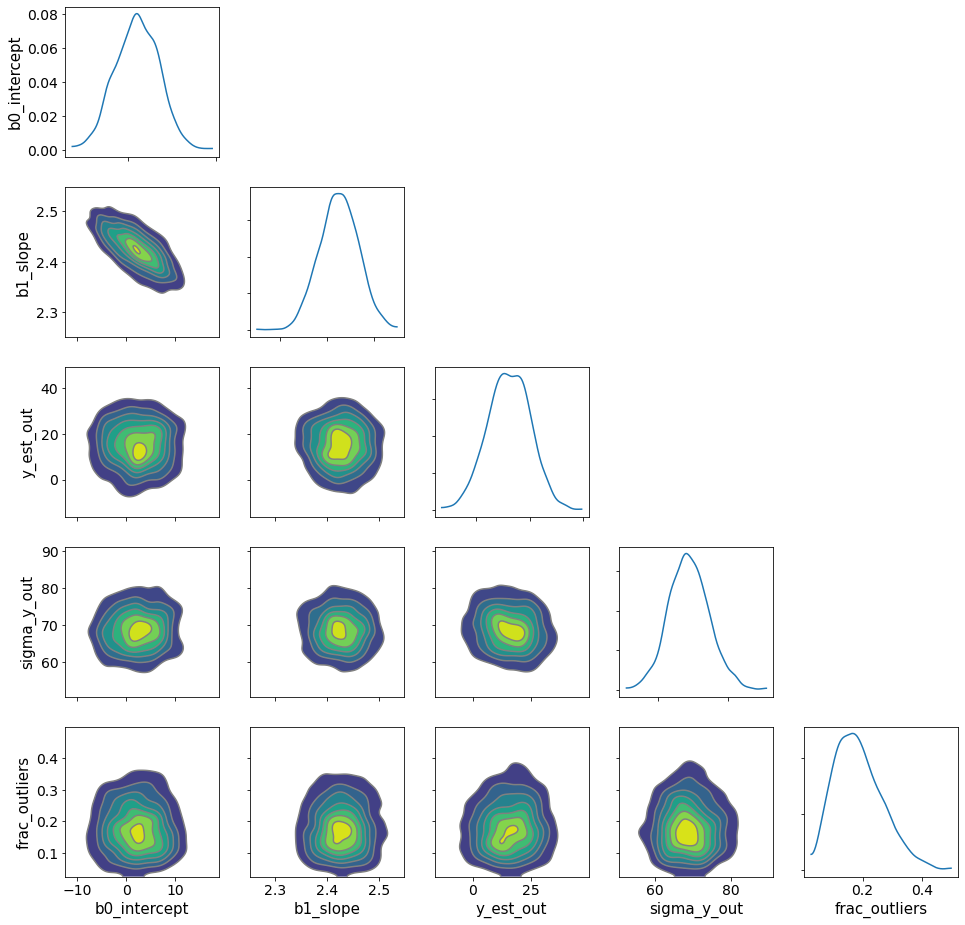

In [ ]:
#Mixture-model likelihood example goes here

with pm.Model() as outlier_mixture:

    # state input data as Theano shared vars
    tsv_x = pm.Data("tsv_x", dfhoggs["x"])  # (n, )
    tsv_y = pm.Data("tsv_y", dfhoggs["y"])  # (n, )
    tsv_sigma_y = pm.Data("tsv_sigma_y", dfhoggs["sigma_y"])  # (n, )

    # weakly informative Normal priors (L2 ridge reg) for inliers
    b0 = pm.Normal("b0_intercept", mu=0, sigma=5, testval=pm.floatX(0.0))
    b1 = pm.Normal("b1_slope", mu=0, sigma=5, testval=pm.floatX(1.0))

    # linear model for mean for inliers
    y_est_in = b0 + b1 * tsv_x  # (n, )

    # very weakly informative mean for all outliers
    y_est_out = pm.Normal("y_est_out", mu=0, sigma=10, testval=pm.floatX(0.0))  # (1, )

    # very weakly informative prior for additional variance for outliers
    sigma_y_out = pm.HalfNormal("sigma_y_out", sigma=10, testval=pm.floatX(1.0))  # (1, )

    # create in/outlier distributions to get a logp evaluated on the observed y
    # this is not strictly a pymc3 likelihood, but behaves like one when we
    # evaluate it within a Potential (which is minimised)
    inlier_logp = pm.Normal.dist(mu=y_est_in, sigma=tsv_sigma_y).logp(tsv_y)

    outlier_logp = pm.Normal.dist(mu=y_est_out, sigma=tsv_sigma_y + sigma_y_out).logp(tsv_y)

    # frac_outliers only needs to span [0, .5]
    # testval for is_outlier initialised in order to create class asymmetry
    frac_outliers = pm.Uniform("frac_outliers", lower=0.0, upper=0.5)
    is_outlier = pm.Bernoulli(
        "is_outlier",
        p=frac_outliers,
        shape=tsv_x.eval().shape[0],
        testval=(np.random.rand(tsv_x.eval().shape[0]) < 0.4) * 1,
    )  # (n, )

    # non-sampled Potential evaluates the Normal.dist.logp's
    potential = pm.Potential(
        "obs",
        ((1 - is_outlier) * inlier_logp).sum() + (is_outlier * outlier_logp).sum(),
    )

    trace_mixture = pm.sample(
        tune=10000,
        draws=500,
        chains=4,
        nuts={"target_accept": 0.99},
        return_inferencedata=True,
    )

    rvs = ["b0_intercept", "b1_slope", "y_est_out", "sigma_y_out", "frac_outliers"]
    az.plot_trace(trace_mixture, var_names=rvs)

    az.summary(trace_mixture, var_names=rvs)

    az.plot_pair(
    data=trace_mixture,
    var_names=rvs,
    kind="kde",
    fill_last=True,
    #divergences=True,
    figsize=[16, 16],
    marginals=True,
    #group="posterior",
    )

    #Classify objects as outliers:
    cutoff = 0.05
    dfhoggs["classed_as_outlier"] = (
        np.quantile(trace_mixture.posterior["is_outlier"][:, -1], cutoff, axis=0) == 1
    )
    dfhoggs["classed_as_outlier"].value_counts()

For comparison, we can fit the same dataset with a Gaussian likelihood, and see how the three methods compare.

In [ ]:
with pm.Model() as normal:

    ## Define weakly informative Normal priors to give Ridge regression
    b0 = pm.Normal("b0_intercept", mu=0, sigma=10)
    b1 = pm.Normal("b1_slope", mu=0, sigma=10)

    ## Define linear model
    y_est = b0 + b1 * dfhoggs["x"]

    ## Define Normal likelihood
    likelihood = pm.Normal("likelihood", mu=y_est, sigma=dfhoggs["sigma_y"], observed=dfhoggs["y"])

    trace_normal = pm.sample(
        tune=5000,
        draws=500,
        chains=4,
        n_init=50000,
        progressbar=True,
        return_inferencedata=True,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [b1_slope, b0_intercept]


Sampling 4 chains for 5_000 tune and 500 draw iterations (20_000 + 2_000 draws total) took 22 seconds.
The acceptance probability does not match the target. It is 0.8811442547605313, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


/usr/local/lib/python3.7/dist-packages/arviz/plots/pairplot.py:183: UserWarning: fill_last and contour will be deprecated. Please use kde_kwargs
  UserWarning,
/usr/local/lib/python3.7/dist-packages/arviz/plots/pairplot.py:183: UserWarning: fill_last and contour will be deprecated. Please use kde_kwargs
  UserWarning,
/usr/local/lib/python3.7/dist-packages/arviz/plots/pairplot.py:183: UserWarning: fill_last and contour will be deprecated. Please use kde_kwargs
  UserWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efe22225350>,
        None],
      dtype=object)

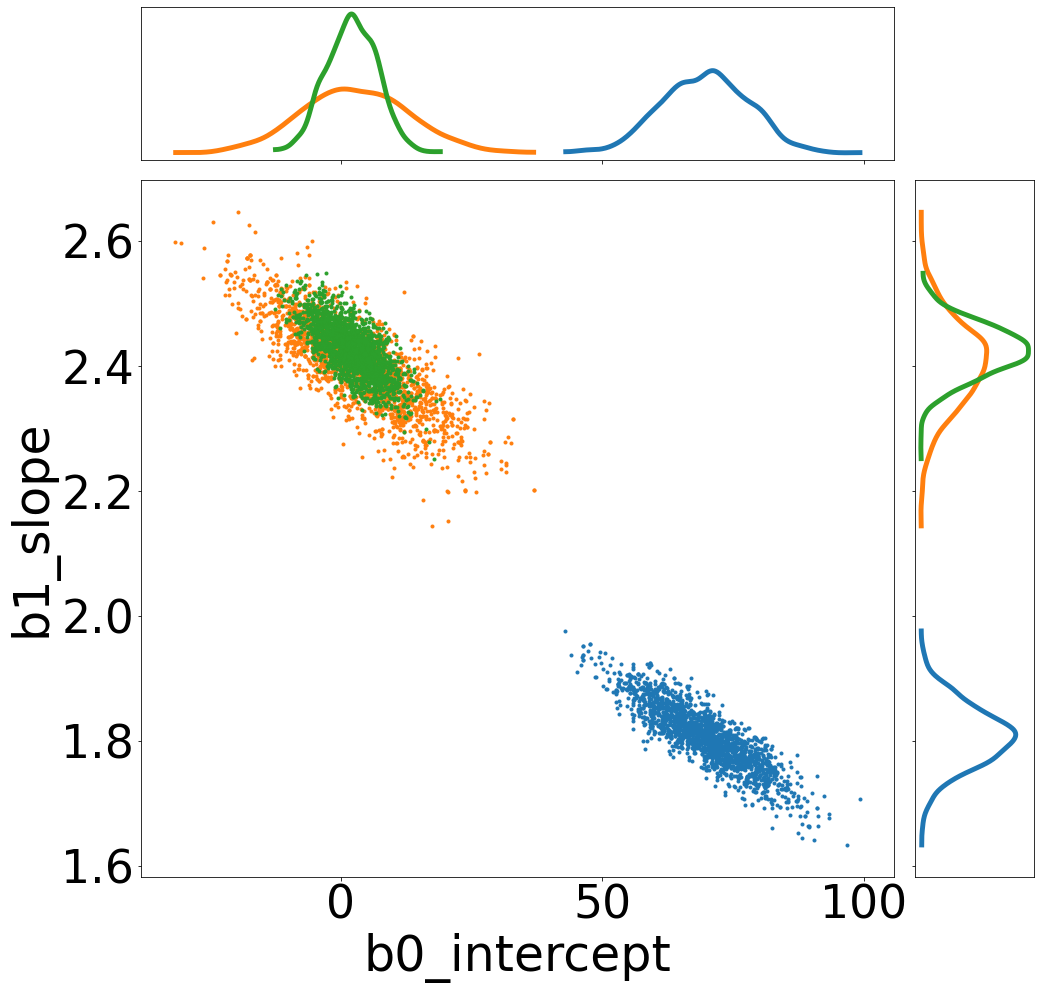

In [ ]:
fts = ["b0_intercept", "b1_slope"]

marginalKwards = {"kind": "kde", "color": sns.color_palette()[0]}


ax = az.plot_pair(
    trace_normal,
    var_names=fts,
    kind="scatter",
    contour=True,
    fill_last=True,
    divergences=True,
    figsize=[16, 16],
    marginals=True,
    marginal_kwargs=marginalKwards,
    group="posterior",
)

marginalKwards = {"kind": "kde", "color": sns.color_palette()[1]}
ax2 = az.plot_pair(
    trace_T,
    var_names=fts,
    kind="scatter",
    fill_last=True,
    divergences=True,
    figsize=[16, 16],
    marginals=True,
    marginal_kwargs=marginalKwards,
    group="posterior",
    ax=ax,
)

marginalKwards = {"kind": "kde", "color": sns.color_palette()[2]}
az.plot_pair(
    data=trace_mixture,
    var_names=fts,
    kind="scatter",
    contour=True,
    fill_last=True,
    divergences=True,
    figsize=[16, 16],
    marginals=True,
    marginal_kwargs=marginalKwards,
    group="posterior",
    ax=ax2,
)

Notice how different the normal (blue) model is from the T-distributed (orange) and outlier (green) models. Both the T and outlier models correctly identify the right region of parameter space, but the outlier model gives significantly higher precision on the inferred parameters. However, this comes at the expense of a runtime which is nearly 10 times longer.

/usr/local/lib/python3.7/dist-packages/pymc3/plots/posteriorplot.py:62: DeprecationWarning: The `plot_posterior_predictive_glm` function will migrate to Arviz in a future release. 
Keep up to date with `ArviZ <https://arviz-devs.github.io/arviz/>`_ for future updates.
  DeprecationWarning,
/usr/local/lib/python3.7/dist-packages/pymc3/plots/posteriorplot.py:62: DeprecationWarning: The `plot_posterior_predictive_glm` function will migrate to Arviz in a future release. 
Keep up to date with `ArviZ <https://arviz-devs.github.io/arviz/>`_ for future updates.
  DeprecationWarning,
/usr/local/lib/python3.7/dist-packages/pymc3/plots/posteriorplot.py:62: DeprecationWarning: The `plot_posterior_predictive_glm` function will migrate to Arviz in a future release. 
Keep up to date with `ArviZ <https://arviz-devs.github.io/arviz/>`_ for future updates.
  DeprecationWarning,


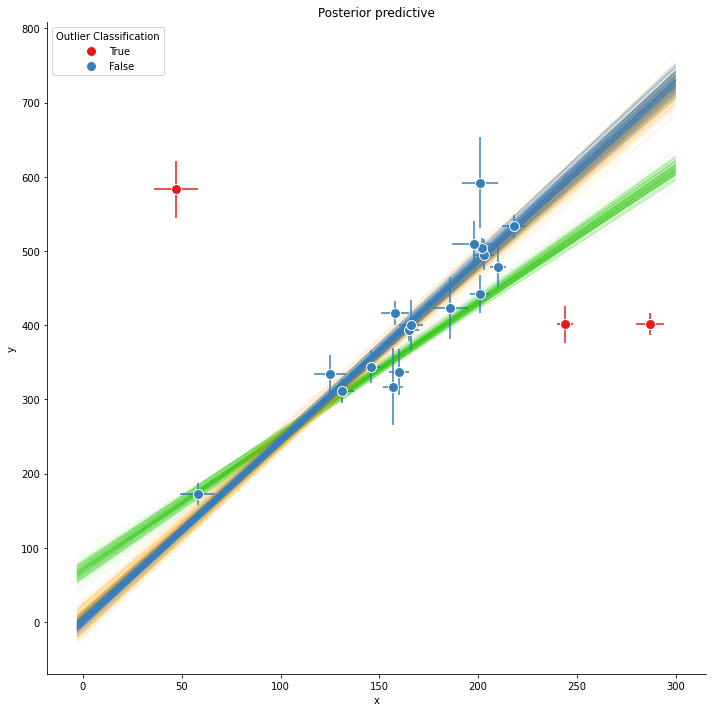

In [ ]:
gd = sns.FacetGrid(
    dfhoggs,
    height=10,
    hue="classed_as_outlier",
    hue_order=[True, False],
    palette="Set1",
    legend_out=False,
)

# plot the 3 model (inlier) posterior distributions
lm = lambda x, s: s["b0_intercept"] + s["b1_slope"] * x

pm.plot_posterior_predictive_glm(
    trace_normal,
    lm=lm,
    eval=np.linspace(-3, 300, 10),
    samples=200,
    color="#357EC7",
    alpha=0.3,
    zorder=2,
)

pm.plot_posterior_predictive_glm(
    trace_T,
    lm=lm,
    eval=np.linspace(-3, 300, 10),
    samples=200,
    color="#FFA500",
    alpha=0.5,
    zorder=3,
)

pm.plot_posterior_predictive_glm(
    trace_mixture,
    lm=lm,
    eval=np.linspace(-3, 300, 10),
    samples=200,
    color="#22CC00",
    alpha=0.5,
    zorder=4.0,
)

# line_legend = plt.legend(
#     [
#         Line2D([0], [0], color="#357EC7"),
#         Line2D([0], [0], color="#CC4444"),
#         Line2D([0], [0], color="#FFA500"),
#         Line2D([0], [0], color="#22CC00"),
#     ],
#     ["Hogg Inlier", "Hogg Outlier", "Student-T", "OLS"],
#     loc="lower right",
#     title="Posterior Predictive",
# )
# _ = gd.fig.get_axes()[0].add_artist(line_legend)

# plot points
_ = gd.map(
    plt.errorbar,
    "x",
    "y",
    "sigma_y",
    "sigma_x",
    marker="o",
    ls="",
    markeredgecolor="w",
    markersize=10,
    zorder=5,
).add_legend()
_ = gd.ax.legend(loc="upper left", title="Outlier Classification")

<a name="blackbody"></a>
### 3. Fitting a blackbody

The (modified) blackbody function is on of the most important in astrophysics. We use it all the time to interpret observations in different settings. The code below takes some data for cold dust emission and attempts to fit them with a modified black body using emcee. When you look at the results, you will notice that the posterior is significantly non-Gaussian -  there are strong correlations between the parameters. This is a clear case where using MCMC gives important information that you could not have discovered from optimisation alone (e.g. least-square minimsation). For brevity, this one is only implemented with emcee - try it yourself with other codes!

4.3.1


100%|██████████| 500/500 [02:55<00:00,  2.85it/s]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

[[ 1.51706472 -9.40810789 -0.85826944]
 [-9.40810789 76.16844238  6.33590621]
 [-0.85826944  6.33590621  0.66215524]]


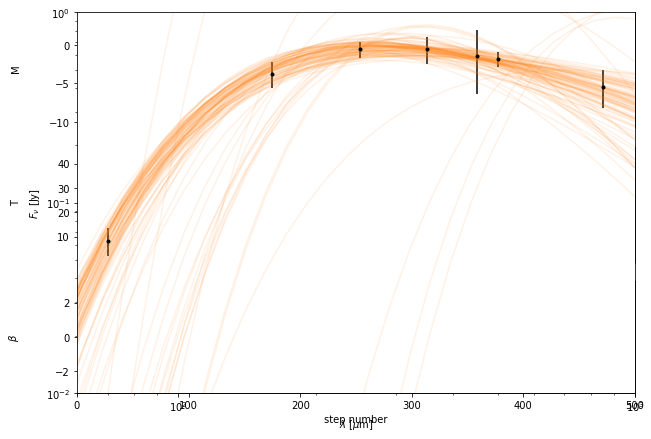

<Figure size 432x288 with 0 Axes>

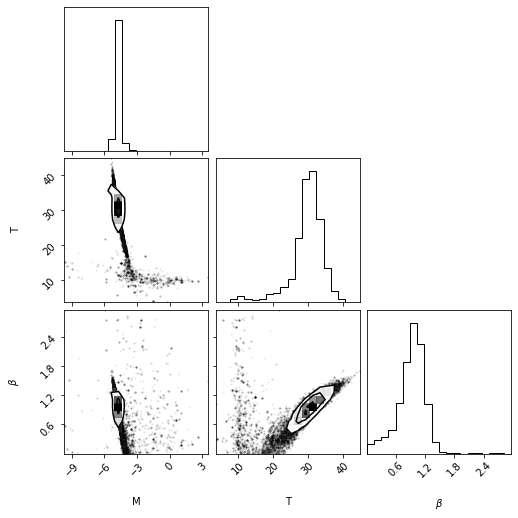

In [ ]:
import numpy as np #numpy is installed by default
#But you can also install packages that you need using pip
try:
  import emcee
except ImportError:
  !pip install emcee
  import emcee
try:
  from astropy import constants as const
except ImportError:
  !pip install astropy
  from astropy import constants as const
from astropy import units as u
from astropy.modeling.physical_models import BlackBody
try:
  import corner
except ImportError:
  !pip install corner
  import corner

import warnings
warnings.filterwarnings("ignore", message="BlackBody provides the same capabilities")
warnings.filterwarnings("ignore", message="invalid value encountered in double_scalars")

#Here's some data: These are observations of the flux of XXX from XXXXX
x = np.array([70., 160., 250., 350., 500., 450., 850.]) #Wavelengths in micron
y = np.array([0.06291731942186395, 0.4737297147415956,
              0.6390202295454346, 0.6397258752453974,
              0.5666783622052882, 0.5923100333782477,
              0.4048189704746445])#np.array([10, 12, 9, 7, 4, 3, 1]) #Fluxes in Jy
yerr = np.array([0.010727567289237351, 0.07215265086492663,
                 0.06050432065824665, 0.10415758267647844,
                 0.052355096848173376, 0.21872154153894846,
                 0.09148243225657898])#np.array([2, 2, 2, 2, 2, 2, 1]) #Uncertainties on the fluxes

normWave = 160. #wavelength (in micron) at which dust opacity is normalised
sigmaNormWave = 0.3 #opacity/mass-absorption coefficient of the dust at normWave
dist = 100*u.pc.to(u.m) #Distance to the star
bb_model = BlackBody()

def model(M, T, beta, lam):
  #convert lambda to nu
  freq = const.c.value / (lam*1e-6)
  scale = 10**(M)*const.M_sun.value * sigmaNormWave * ((lam / normWave)**beta)

  bb = bb_model.evaluate(x=freq,temperature=T, scale=scale)*u.erg / (u.cm ** 2 * u.s * u.Hz * u.sr)
  bb = bb.to(u.Jy / u.sr).value
  bb = bb / dist**2
  return bb

from scipy.stats import norm
def lnprior(theta):
  #This is our new prior - probability is limited to a given range where T is expected to be normally distributed, and zero outside
  if -10 < theta[0] < 10 and 3 < theta[1] < 100 and -3 < theta[2] < 3:
    return norm.logpdf(theta[1], 20, 10) #T prior has a mean of 20K with a standard deviation of 10K
  return -np.inf

def lnlike(theta, x, y, yerr):
  #This function calculates the likelihood P(D|M) for our model.
  M = theta[0]
  T = theta[1]
  beta = theta[2]
  flux = model(M, T, beta, x)
  return-0.5* np.sum((y - flux)**2 /yerr**2)

def lnprob(theta, x, y, yerr):
  lp = lnprior(theta)
  if lp == -np.inf:
    return lp
  return lp + lnlike(theta, x, y, yerr)

#Now we have a model, and we have defined our posterior, we can set up a sampler and get things moving.
ndim=3 #Three dimensions for this problem - M, T and beta
nwalkers=100 #emcee is an affine-invariant ensemble sampler. This means it uses several chains.
             # the number of walkers (=chains) must be even, and should be as large as possible (at least double ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))

steps = 500
pos = [[0, 10, 0] + np.random.randn(ndim) for i in range(nwalkers)]
sampler.run_mcmc(pos,steps, progress=True)

#get the chains from the sampler
samples = sampler.get_chain()
flat_samples = sampler.get_chain(flat=True)

import matplotlib.pyplot as plt

#trace plots first

fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
fig.patch.set_facecolor('white')
labels = ["M", "T", r"$\beta$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

import warnings
warnings.filterwarnings("ignore", message="BlackBody provides the same capabilities")

figpp = plt.figure()
axpp = fig.add_subplot(111)
inds = np.random.randint(len(flat_samples), size=100)
plot_x = np.logspace(np.log10(50), np.log10(1000), 30)
for ind in inds:
    sample = flat_samples[ind]
    axpp.plot(plot_x, model(sample[0], sample[1], sample[2], plot_x), "C1", alpha=0.1)
axpp.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
#plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
#plt.legend(fontsize=14)
axpp.set_xlim(60, 1000)
axpp.set_ylim(0.01, 1)
axpp.set_xscale('log')
axpp.set_yscale('log')
axpp.set_xlabel(r"$\lambda$ [$\mu$m]")
axpp.set_ylabel(r"$F_\nu$ [Jy]");

from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i]).replace("$", "")
    display(Math(txt))

#import corner

#mask_samples = np.logical_and(flat_samples)
fig = corner.corner(
    flat_samples[flat_samples[:,2] > 0], labels=labels#, truths=[m_true, b_true, np.log(f_true)]
);
fig.patch.set_facecolor('white')

cov = np.cov(flat_samples, rowvar=False)
print(cov)

This model is actually incomplete. What key piece of physics is missing from the model? _Hint:_ it's related to how the observations are actually performed. If you figure it out, see if you can implement it as a bonus problem.

<a name="correlation"></a>
### 4. Correlation coefficients

As researchers, we frequently want to explore whether two observed variables are correlated or not. Historically, the Pearson-r and Spearman rank-rho correlation coefficients have been popular, but they do not give any impression of how _significant_ a correlation is. More useful is to model the correlation as if the data are drawn from a multivariate normal distribution, and explore the posterior of distributions that reproduce the data. This is a case where PPLs can be very useful and make the problem easy to understand.

In [ ]:
corr_model = pm.Model()
mu_prior=[0.0,1000.]
sigma_prior=200.
#for convenience, we will re-use the x and y data from the linear regression problem, but bear in mind that these really are correlated.
data = np.column_stack((x,y))
with corr_model:
    #we put weakly informative priors on the means and standard deviations of the multivariate normal distribution
    mu = pm.Normal("mu", mu=mu_prior[0], sigma=mu_prior[1], shape=ndim)
    sigma = pm.HalfCauchy.dist(sigma_prior)
    #and a prior on the covariance matrix which weakly penalises strong correlations
    chol, corr, stds = pm.LKJCholeskyCov("chol", n=ndim, eta=2.0, sd_dist=sigma, compute_corr=True)
    #the prior gives us the Cholesky Decomposition of the covariance matrix, so for completeness we can calculate that determinisitically
    cov = pm.Deterministic("cov", chol.dot(chol.T))

    #and now we can put our observed values into a multivariate normal to complete the model
    vals = pm.MvNormal('vals', mu=mu, chol=chol, observed=data)

    trace_cov = pm.sample(5000, target_accept=0.9,return_inferencedata=True
            )
    summary = az.summary(trace_cov, var_names=["~chol"], round_to=2)

In [ ]:
print(summary)

This is a basic introduction to the problem, you can find a variety of descriptions of how this works. The question has been generalised to correlation coeffiients in the presence of measurement uncertainty and to arbitrary dimension. These cases are implemented in the **_pybaycor_** package using pymc3. Try out this example with your own data:

In [ ]:
try:
    import pybaycor as pbc
except ImportError:
    !pip install pybaycor
    import pybaycor as pbc
#import your data here:

#Then reshape your data so that it is a M * N numpy array, where M is the number of points in your dataset, and N is the number of dimensions
#So if you want to look for the correlation between e.g. flux and temoerature for a sample of 200 dust clouds, your data should have the shape (200, 2)

#Now reshape your uncertainties so that they have the same shape as the data

#Now we can pass this to pybaycor. We will use the case of infering a correlation in the presence of measurement uncertainty.
corr = pbc.HierarchicalBayesianCorrelation(data, sigma)

#There are also options for data without uncertainties (pbc.BayesianCorrelation),
#and robust versions for both with and without uncertainties, in which a T-distribution is used instead
#of a Normal distribution (RobustBayesianCorrelation and HierarchicalRobustBayesianCorrelation)
#Try them out!

trace = corr.fit() #This step does the MCMC, and can take a little while

#These methods provide output
corr.summarise() #The summary
corr.plot_trace() # trace plots
corr.plot_data() #and the posterior-predictive

#This is a hierarchical model, so we can separately examine the summary for the model parameters and the data
corr.model_summary() #This gives the means and correlation matrix of the Gaussian
corr.data_summary() #This gives the inferred data points and uncertainties assuming they really are drawn from a multivariate Gaussian


<a name="problems"></a>
# Problems

Finally, here are a set of problems for you to try. Some of them build directly on the problems laid out above, and some are completely new.

<a name="moreregression"></a>
## 1. Further regression

<a name="underestimatederror"></a>
### 1. Underestimated uncertainty

In the first simple example, we fitted a line to data assuming that the uncertainties were reasonably well estimated. However, this is often not the case - we often have to worry about additional sources of uncertainty beyond those directly accounted for. In such cases, we can introduce an additional parameter to out model and attempt to infer how bad the uncertainty estimation is. Try to construct a model/likelihood for this case and see if the data used above is consistent with underestimated uncertainty or not. Ideally, try it with both black-box and PPL approaches.

<a name="intrinsicscatter"></a>
### 2. Intrinsic scatter

What if we have an additional source of uncertainty which is not multiplicative with the measured uncertainties, but corresponds to additional, unmodelled physics? In this case, we often talk about _intrinsic scatter_. Take a look at the example with 2D uncertainties, and try to implement a model with additional Gaussian scatter. Try to infer the amount of additional scatter required to fit the data.

<a name="moreD"></a>
### 3. Higher-dimensional lines

Produce your own synthetic data, and try to generalise the 2D uncertainty case to 3 dimensions, or ideally N dimensions. Don't worry about intrinsic scatter here, although you can consider that a bonus problem.

<a name="poisson"></a>
### 4. Non-Gaussian likelihoods

We took a little peak at this in the example of regression with outliers. A classic astronomy problem where the Gaussian approximation is bad is when dealing with counting photons, or their rates. Assume that the y values used in the first example are the logarithm of _count rates_ instead of just numbers, and try to repeat the fits. What distribution are they drawn from? This should be relatively straightfoward with a PPL, so try that first. Then try again with emcee.

<a name="conv_prob"></a>
## 2. Checking convergence

Take the 3rd example, fitting a blackbody, and check if it has converged appropriately. If not, how long does it need to run for? Try importing the results from emcee to arviz and compute the ESS and R-hat.

<a name="ppc_prob"></a>
## 3. Posterior Predictive Checks

The code block below contains some data and a model for it. Is the model appropriate for the data? Compare alternative models and see which one is the most appropriate.

In [ ]:
x = np.array([ 0.        ,  0.1010101 ,  0.2020202 ,  0.3030303 ,  0.4040404 ,
        0.50505051,  0.60606061,  0.70707071,  0.80808081,  0.90909091,
        1.01010101,  1.11111111,  1.21212121,  1.31313131,  1.41414141,
        1.51515152,  1.61616162,  1.71717172,  1.81818182,  1.91919192,
        2.02020202,  2.12121212,  2.22222222,  2.32323232,  2.42424242,
        2.52525253,  2.62626263,  2.72727273,  2.82828283,  2.92929293,
        3.03030303,  3.13131313,  3.23232323,  3.33333333,  3.43434343,
        3.53535354,  3.63636364,  3.73737374,  3.83838384,  3.93939394,
        4.04040404,  4.14141414,  4.24242424,  4.34343434,  4.44444444,
        4.54545455,  4.64646465,  4.74747475,  4.84848485,  4.94949495,
        5.05050505,  5.15151515,  5.25252525,  5.35353535,  5.45454545,
        5.55555556,  5.65656566,  5.75757576,  5.85858586,  5.95959596,
        6.06060606,  6.16161616,  6.26262626,  6.36363636,  6.46464646,
        6.56565657,  6.66666667,  6.76767677,  6.86868687,  6.96969697,
        7.07070707,  7.17171717,  7.27272727,  7.37373737,  7.47474747,
        7.57575758,  7.67676768,  7.77777778,  7.87878788,  7.97979798,
        8.08080808,  8.18181818,  8.28282828,  8.38383838,  8.48484848,
        8.58585859,  8.68686869,  8.78787879,  8.88888889,  8.98989899,
        9.09090909,  9.19191919,  9.29292929,  9.39393939,  9.49494949,
        9.5959596 ,  9.6969697 ,  9.7979798 ,  9.8989899 , 10.        ])
y = np.array([0.60614598, 0.6153662 , 0.47419432, 0.64142881, 0.5404495 ,
       0.65958241, 0.5388796 , 0.72837078, 0.56604171, 0.86397498,
       0.4751028 , 0.4119352 , 0.53598582, 1.04707218, 0.83268879,
       0.65939936, 0.71741511, 0.79977691, 0.76297566, 0.56573409,
       0.68881211, 0.93441395, 1.08102487, 1.06692672, 0.91861211,
       1.14857326, 0.98065209, 0.99522437, 0.98278417, 1.11751265,
       0.79828341, 0.18980406, 1.11795621, 1.16912414, 1.08937796,
       1.05315588, 0.95460981, 1.35636458, 1.5210485 , 1.70122012,
       1.8312029 , 2.50786172, 2.80173261, 3.10481785, 2.62385979,
       2.20492704, 1.6121115 , 1.64443925, 1.69162613, 0.96340852,
       0.86319356, 0.61203334, 0.87827908, 0.73654364, 0.99289407,
       0.74860198, 0.5520727 , 0.74797704, 0.60877654, 0.48734763,
       0.41548919, 0.47134843, 0.65060695, 0.55424859, 0.53872972,
       0.42004391, 0.50261679, 0.41800777, 0.14338189, 0.39985653,
       0.34840721, 0.37024026, 0.57578898, 0.16391488, 0.36135355,
       0.36556374, 0.72052741, 0.49379491, 0.58735107, 0.24443858,
       0.44170883, 0.498692  , 0.51745757, 0.45058975, 0.25297367,
       0.57483966, 0.29939929, 0.5941698 , 0.35649874, 0.56844186,
       0.45872986, 0.36447514, 0.52903476, 0.51461255, 0.70671988,
       0.36093269, 0.63303675, 0.76049668, 1.0671897 , 0.58650049])
yerr = np.array([0.13571468, 0.17649925, 0.2427158 , 0.19674616, 0.1374289 ,
       0.13734713, 0.23344185, 0.13494697, 0.16865474, 0.14877157,
       0.1523842 , 0.21276768, 0.21248585, 0.23104686, 0.2186303 ,
       0.16633297, 0.12466968, 0.19250511, 0.23896049, 0.24204692,
       0.11889055, 0.20328089, 0.19548629, 0.1582987 , 0.18590566,
       0.24759034, 0.23386036, 0.14216423, 0.18593009, 0.2357429 ,
       0.21747414, 0.24222248, 0.17103163, 0.1992606 , 0.15450062,
       0.22667307, 0.23436873, 0.11204839, 0.11259136, 0.11087712,
       0.23634978, 0.17765576, 0.24790074, 0.15669243, 0.1050639 ,
       0.11204431, 0.13651244, 0.14456857, 0.24083602, 0.21794055,
       0.18097375, 0.13599461, 0.23872987, 0.10324854, 0.24533545,
       0.12294229, 0.16149936, 0.10591347, 0.21025653, 0.18675912,
       0.16242686, 0.16716389, 0.18856679, 0.11728497, 0.11803215,
       0.15240304, 0.12481872, 0.17082965, 0.24074905, 0.13743163,
       0.23039399, 0.21941084, 0.24978922, 0.19685753, 0.16923487,
       0.22468505, 0.18220194, 0.10126559, 0.16738149, 0.13034307,
       0.16072441, 0.12061447, 0.15581466, 0.18634505, 0.21928294,
       0.12790317, 0.21768046, 0.15576875, 0.19392913, 0.10682687,
       0.18502616, 0.17874781, 0.1710912 , 0.12937686, 0.20394657,
       0.13313035, 0.10067853, 0.24100547, 0.18669291, 0.19211422])

def model(x, centre, width, int_intens, baseline):
  #A model for a spectral line described by a gaussian, normalised by integrated intensity
  return int_intens*norm.pdf(x, centre, width) + baseline

def lnlike(theta, x, y, yerr):
  #This function calculates the likelihood P(D|M) for our model.
  centre = theta[0]
  width = theta[1]
  int_intens = theta[2]
  baseline = theta[3]
  flux = model(x, centre, width, int_intens, baseline)
  return-0.5* np.sum((y - flux)**2 /yerr**2)

def lnprior(theta):
  #This is a flat prior - probability is uniform inside a given range, and zero outside
  if -10 < theta[0] < 10 and 0 < theta[1] < 100 and 0 < theta[2] < 3 and -10 < theta[3] < 10:
    return 0
  return -np.inf

def lnprob(theta, x, y, yerr):
  lp = lnprior(theta)
  if lp == -np.inf:
    return lp
  return lp + lnlike(theta, x, y, yerr)


ndim=4 #Three dimensions for this problem - M, T and beta
nwalkers=100 #emcee is an affine-invariant ensemble sampler. This means it uses several chains.
             # the number of walkers (=chains) must be even, and should be as large as possible (at least double ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))

steps = 500
pos = [[0, 1, 0, 0] + np.random.randn(ndim) for i in range(nwalkers)]
sampler.run_mcmc(pos,steps)

<a name="nuisance_prob"></a>
## 4. Nuisance Parameters

Go back to the modified blackbody example given above. In that case we assumed that the distance is a delta function (known exactly). In most cases, however, we have a measured distance with an uncertainty, possibly from parallax measurements. Attempt to re-write this example to assume that the distance can be constrained by a parallax of 10 +/- 1 milliarcseconds, and marginalise out this constraint to see what effect this has on the posterior distribution of the mass.

<a name="prior_prob"></a>
## 5. Prior sensitivity tests

In our first example, we tried out a second prior and saw that it made little difference to the results. Repeat this test with a wider range of priors and see how extreme you have to make them to significantly affect the outcome.

<a name="update"></a>
## 6. Bayesian Updating

The first lecture covered the important concept of Bayesian Updating - using the outcome of a first experiment to inform the prior of a second. Try to replicate this with MCMC. First, generate some synthetic data and fit it with uninformative priors. Then, generate a second batch of synthetic data from the same function, and create priors informed by the outcome of the first fit, and fit the second batch of data.

Why can't we fit the same batch of data twice, using the posterior of the first fit as a prior on the second?

# Footnotes
<a name="cite_note-1"></a>1. [^](#cite_ref-1) But it's not impossible - see [this tutorial](https://docs.pymc.io/en/v3/pymc-examples/examples/case_studies/blackbox_external_likelihood.html) or [this colab notebook](https://colab.research.google.com/github/pymc-devs/pymc-examples/blob/main/examples/case_studies/blackbox_external_likelihood_numpy.ipynb) for examples in PyMC3.